### Flipping Houses in a Decentralized Market
# Jakub Pawelczak JMP 2024

## Main code
Code below solves household problems
$$\sigma(\delta)\Delta V(\delta)=\delta+\gamma\int_0^1\Delta V(\delta')dG(\delta')+\lambda F(0)\Delta V(\delta_1) 1[\delta<\delta_1]+\lambda F(1)\Delta V(\delta_0) 1[\delta>\delta_0]+$$
 $$+\frac{\rho}{2}\int_\delta^1 \Delta V(\delta') dH(0,\delta')+\frac{\rho}{2}\int_0^\delta  \Delta V(\delta') dH(1,\delta')$$
 where
$$\sigma(\delta)=r+\gamma+\lambda F(0) 1[\delta<\delta_1]+\lambda F(1) 1[\delta>\delta_0]+\frac{\rho}{2}\int_\delta^1 dH(0,\delta')+\frac{\rho}{2}\int_0^\delta dH(1,\delta')$$
flippers problems
$$ r W(1)=\max_{P_1} \lambda\int_{0}^{\bar{\delta}} dH(0,\delta)[P_1 +W(0)-W(1)]$$
$$r W(0)=\max_{P_0} \lambda\int_{0}^{\bar{\delta}}dH(1,\delta)[-P_0 +W(1)-W(0)] $$

and distributions using
$$     \int^{\bar{\delta}}_0 dH(1,\delta) + F(1)=s$$
$$ \quad \int_0^{\delta} dH(0,\delta)+\int_0^{\delta}dH(1,\delta)=G(\delta) \quad \forall \delta \in [0,\bar{\delta}]$$
$$    F(0)+F(1)=f$$
$$     \lambda F(1)\int_{\delta_0^*}^{\max\{\delta,\delta_0^*\}}dH(0,\delta')+\gamma G(\delta)\int^{1}_{\delta}dH(1,\delta')=\lambda F(0)\int_0^{\min\{\delta,\delta_1^*\}}dH(1,\delta')+\gamma (1-G(\delta))\int_0^{\delta}dH(1,\delta')+ \rho\int_0^\delta dH(1,\delta')\int_\delta^1 dH(0,\delta')$$

## Parameters

In [1]:
import numpy as np
from scipy.integrate import quad
from scipy.optimize import fsolve
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import time
from scipy.optimize import minimize
from scipy.integrate import IntegrationWarning
from scipy.integrate import quad, simps
import warnings
import seaborn as sns

warnings.filterwarnings("ignore")

# Configure matplotlib to use the pgf backend
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",  # Change this if using xelatex or lualatex
    "text.usetex": True,          # Use LaTeX to write all text
    "font.family": "serif",
    "axes.labelsize": 25,         # LaTeX default is 10pt font.
    "font.size": 20,
    "legend.fontsize": 20,
    "xtick.labelsize": 25,
    "ytick.labelsize": 25,
    "axes.titlesize": 30, 
    "pgf.preamble": r"""
        \usepackage[utf8]{inputenc}    # Use UTF8 input encoding
        \usepackage[T1]{fontenc}       # Use T1 fonts
        \usepackage{amsmath}           # For math
    """
})

# Constants
s = 0.6884162140
r = 0.0361577940

delta_bar = 1
N_points = 101
delta_grid = np.linspace(0, delta_bar, N_points)

# Parameters
f,gamma,rho,lambda1,delta_0_star_initial, delta_1_star_initial=0.021,0.07,0.3,3,0.483672706,0.106481650304695

delta_bar = 1
N_points = 101
delta_grid = np.linspace(0, delta_bar, N_points)
grid_spacing = delta_grid[1] - delta_grid[0]

fixed_params = {
    'f': f,
    's': s,
    'r': r,
    'gamma': gamma,
    'rho': rho,
    'lambda1': lambda1
}

## Solving model

In [2]:
# Define the case functions for H1
def H1_case_C(delta, F1_val, r, gamma, s, f, lambda1, rho):
    a = rho
    b = lambda1 * (f - F1_val) + gamma + rho * (1 - delta/delta_bar - s + F1_val)
    c = -gamma * delta * (s - F1_val)/delta_bar
    discriminant = b**2 - 4 * a * c
    if a == 0:
        H1_delta = -c / b
    elif discriminant >= 0:
        H1_delta = (-b + np.sqrt(discriminant)) / (2 * a)
    else:
        H1_delta = (-b) / (2 * a)  # Fallback: Use the midpoint formula when discriminant is negative
    return H1_delta

def H1_case_D(delta, H1_delta1, F1_val, r, gamma, s, f, lambda1, rho):
    a = rho
    b = gamma  + rho * (1 - delta/delta_bar - s + F1_val) 
    c = -gamma * delta * (s - F1_val)/delta_bar + lambda1 * (f - F1_val) * H1_delta1
    discriminant = b**2 - 4 * a * c
    if a == 0:
        H1_delta = -c / b
    elif discriminant >= 0:
        H1_delta = (-b + np.sqrt(discriminant)) / (2 * a)
    else:
        H1_delta = (-b) / (2 * a)  # Fallback: Use the midpoint formula when discriminant is negative
    return H1_delta

def H1_case_E(delta, H1_delta0, F1_val, r, gamma, s, f, lambda1, rho, H1_delta1, delta_0_star):
    a = rho
    b = gamma  + rho * (1 - delta/delta_bar - s + F1_val) + lambda1 * F1_val 
    c = - (lambda1 * F1_val * ((delta - delta_0_star)/delta_bar + H1_delta0) 
           + gamma * delta * (s - F1_val)/delta_bar - lambda1 * (f - F1_val) * H1_delta1)
    discriminant = b**2 - 4 * a * c
    if a == 0:
        H1_delta = -c / b
    elif discriminant >= 0:
        H1_delta = (-b + np.sqrt(discriminant)) / (2 * a)
    else:
        H1_delta = (-b) / (2 * a)  # Fallback: Use the midpoint formula when discriminant is negative
    return H1_delta

# Helper functions for H1 and H0 computations
def H1_delta1_comp(F1_val, r, gamma, s, f, lambda1, rho, delta_1_star):
    a = rho
    b = lambda1 * (f - F1_val) + gamma + rho * (1 - delta_1_star /delta_bar- s + F1_val) 
    c = -gamma * delta_1_star * (s - F1_val)/delta_bar
    if a == 0:
        H1_delta1 = -c / b
    else:
        discriminant = b**2 - 4 * a * c
        if discriminant < 0:
            raise ValueError("Negative discriminant in quadratic equation.")
        H1_delta1 = (-b + np.sqrt(discriminant)) / (2 * a)
    return H1_delta1

def H1_delta0_comp(F1_val, H1_delta1, r, gamma, s, f, lambda1, rho, delta_0_star):
    a = rho
    b = gamma  + rho * (1 - delta_0_star/delta_bar - s + F1_val) 
    c = -gamma * delta_0_star * (s - F1_val)/delta_bar + lambda1 * (f - F1_val) * H1_delta1
    if a == 0:
        H1_delta0 = -c / b
    else:
        discriminant = b**2 - 4 * a * c
        if discriminant < 0:
            raise ValueError("Negative discriminant in quadratic equation.")
        H1_delta0 = (-b + np.sqrt(discriminant)) / (2 * a)
    return H1_delta0

def trade_condition(F1_val, r, gamma, s, f, lambda1, rho, delta_1_star, delta_0_star):
    H1_delta1 = H1_delta1_comp(F1_val, r, gamma, s, f, lambda1, rho, delta_1_star)
    H1_delta0 = H1_delta0_comp(F1_val, H1_delta1, r, gamma, s, f, lambda1, rho, delta_0_star)
    left_side = F1_val * (1 - delta_0_star/delta_bar - s + F1_val + H1_delta0)
    right_side = (f - F1_val) * H1_delta1
    return left_side - right_side

# Solver for F1
def solve_F1(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho):
    F1_initial = f
    F1_solution = fsolve(trade_condition, F1_initial, args=(r, gamma, s, f, lambda1, rho, delta_1_star, delta_0_star))
    return F1_solution[0]

def F1(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho):
    return solve_F1(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)

def F0(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho):
    return f - F1(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)

def H1(delta, delta_0_star, delta_1_star, F1_val, r, gamma, s, f, lambda1, rho):
    # Compute the transition values to ensure continuity
    H1_delta1 = H1_case_C(delta_1_star, F1_val, r, gamma, s, f, lambda1, rho)
    H1_delta0 = H1_case_D(delta_0_star, H1_delta1, F1_val, r, gamma, s, f, lambda1, rho)
    
    if 0 < delta <= delta_1_star:
        return H1_case_C(delta, F1_val, r, gamma, s, f, lambda1, rho)
    elif delta_1_star < delta < delta_0_star:
        return H1_case_D(delta, H1_delta1, F1_val, r, gamma, s, f, lambda1, rho)
    elif delta_0_star <= delta <= delta_bar:
        return H1_case_E(delta, H1_delta0, F1_val, r, gamma, s, f, lambda1, rho, H1_delta1, delta_0_star)
    else:
        return 0  # Fallback to avoid returning None

def H0(delta, delta_0_star, delta_1_star, F1_val, r, gamma, s, f, lambda1, rho):
    if 0 < delta <= delta_bar:
        return delta/delta_bar - H1(delta, delta_0_star, delta_1_star, F1_val, r, gamma, s, f, lambda1, rho)
    else:
        return 0

def compute_H_values(delta_grid, delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho):
    F1_val = F1(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
    H1_values = []
    H0_values = []

    for delta in delta_grid:
        
        H1_val = H1(delta, delta_0_star, delta_1_star, F1_val, r, gamma, s, f, lambda1, rho)
        H0_val = H0(delta, delta_0_star, delta_1_star, F1_val, r, gamma, s, f, lambda1, rho)
        # Check for None, NaN, or other invalid values
        if H1_val is None or np.isnan(H1_val):
            H1_val = 0  # Or some other default or error-handling value
        if H0_val is None or np.isnan(H0_val):
            H0_val = 0  # Or some other default or error-handling value
        
        H1_values.append(H1_val)
        H0_values.append(H0_val)

    return np.array(H1_values), np.array(H0_values)

def dH1(delta, delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho):
    F1_val = F1(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
    F0_val = F0(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)

    H1_val = H1(delta, delta_0_star, delta_1_star, F1_val, r, gamma, s, f, lambda1, rho)

    if 0 <= delta <= delta_1_star:
        b = lambda1 * F0_val + gamma + rho * (1 - delta/delta_bar - s + F1_val + 2 * H1_val)
        c = gamma * (s - F1_val)/delta_bar + rho * H1_val
    elif delta_1_star < delta < delta_0_star:
        b = gamma+ rho * (1 - delta/delta_bar - s + F1_val + 2 * H1_val)
        c = gamma * (s - F1_val)/delta_bar + rho * H1_val
    elif delta >= delta_0_star:
        b = lambda1 * F1_val + gamma + rho * (1 - delta/delta_bar - s + F1_val + 2 * H1_val)
        c = lambda1 * F1_val + gamma/delta_bar * (s - F1_val) + rho * H1_val
    else:
        return 0

    return c / b
def dH0(delta, delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho):
    return 1/delta_bar - dH1(delta, delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)

def dH1_gen(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho):
    H1_values, H0_values = compute_H_values(delta_grid, delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)

    dH1_values = np.zeros_like(delta_grid)
    F1_val = F1(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
    F0_val = F0(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
    
    for i, delta in enumerate(delta_grid):
        H1_delta = H1_values[i]
        
        if 0 <= delta <= delta_1_star:
            a = 0
            b = lambda1 * F0_val + gamma + rho * (1 - delta/delta_bar - s + F1_val + 2 * H1_delta)
            c = gamma * (s - F1_val)/delta_bar + rho * H1_delta/delta_bar
        elif delta_1_star < delta < delta_0_star:
            a = 0
            b = gamma + rho * (1 - delta/delta_bar - s + F1_val + 2 * H1_delta)
            c = gamma * (s - F1_val)/delta_bar + rho * H1_delta/delta_bar
        elif delta >= delta_0_star:
            a = 0
            b = lambda1 * F1_val + gamma + rho * (1 - delta/delta_bar - s + F1_val + 2 * H1_delta)
            c = lambda1 * F1_val + gamma * (s - F1_val)/delta_bar + rho * H1_delta/delta_bar
        else:
            dH1_values[i] = 0  # or some default value
            continue  # Skip to the next iteration to avoid unintended behavior
        
        if b != 0:  # To avoid division by zero
            dH1_values[i] = c / b
        else:
            dH1_values[i] = 0  # Handle the special case where b is zero
        
    return np.array(dH1_values)

def dH0_gen(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho):
    
    # Simply return 1 - dH1_gen, which will be an array
    return 1/delta_bar - dH1_gen(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)

def dH0Delta(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho):
    H1_values, H0_values = compute_H_values(delta_grid, delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
    dH0_values = dH0_gen(  delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
    dH1_values = dH1_gen( delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)

    n = len(delta_grid)
    dH0Delta_matrix = np.zeros((n, n))  # Create an n x n matrix filled with zeros
    for i in range(n - 1):
        dH0Delta_matrix[i, i + 1:] = dH0_values[i + 1:] * grid_spacing  # Use the array values here
    return dH0Delta_matrix

def dH1Delta(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho):
    H1_values, H0_values = compute_H_values(delta_grid, delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
    dH0_values = dH0_gen( delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
    dH1_values = dH1_gen( delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)

    n = len(delta_grid)
    dH1Delta_matrix = np.zeros((n, n))  # Create an n x n matrix filled with zeros
    for i in range(1, n):
        dH1Delta_matrix[i, :i] = dH1_values[:i] * grid_spacing  # Use the array values here
    return dH1Delta_matrix

def Sigma(delta_grid, delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho):
    F1_val = F1(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
    F0_val = f - F1_val

    sigma_values = np.zeros_like(delta_grid)
    H0_1 = H0(delta_bar, delta_0_star, delta_1_star, F1_val, r, gamma, s, f, lambda1, rho)
    
    for i, delta in enumerate(delta_grid):
        H0_delta = H0(delta, delta_0_star, delta_1_star, F1_val, r, gamma, s, f, lambda1, rho)
        H1_delta = H1(delta, delta_0_star, delta_1_star, F1_val, r, gamma, s, f, lambda1, rho)
        
        if delta < delta_1_star:
            sigma_values[i] = r + gamma + lambda1 * F0_val + (rho / 2) * (H0_1 - H0_delta) + (rho / 2) * H1_delta
        elif delta_1_star <= delta <= delta_0_star:
            sigma_values[i] = r + gamma + (rho / 2) * (H0_1 - H0_delta) + (rho / 2) * H1_delta
        elif delta > delta_0_star:
            sigma_values[i] = r + gamma + lambda1 * F1_val + (rho / 2) * (H0_1 - H0_delta) + (rho / 2) * H1_delta
    return np.diag(sigma_values)

def dG_outer_1T(delta_grid,r, gamma, s, f, lambda1, rho):
    dG = np.full_like(delta_grid/delta_bar, 1 / len(delta_grid))
    return np.outer(dG, np.ones_like(delta_grid))

def W1(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho):
    # Define the continuous functions
    F1_val = F1(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
    F0_val = F0(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
    
    # Calculate necessary values using continuous functions
    H0_1 = H0(delta_bar, delta_0_star, delta_1_star, F1_val, r, gamma, s, f, lambda1, rho)
    H0_delta0_star = H0(delta_0_star, delta_0_star, delta_1_star, F1_val, r, gamma, s, f, lambda1, rho)
    H1_delta0_star = H1(delta_0_star, delta_0_star, delta_1_star, F1_val, r, gamma, s, f, lambda1, rho)
    
    sigma_delta0 = r + gamma + (rho / 2) * (H0_1 - H0_delta0_star) + (rho / 2) * H1_delta0_star
    

    # Integrate dH0 from delta_0_star to 1
    dH0_delta0 = dH0(delta_0_star, delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
    
    if dH0_delta0 == 0:
        dH0_delta0=0.0000001
    
    return (lambda1 / r) * (H0_1 - H0_delta0_star)**2 / (sigma_delta0 * dH0_delta0)

def W0(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho):
    # Define the continuous functions
    F1_val = F1(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
    F0_val = F0(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
        
    # Calculate necessary values using continuous functions
    H0_1 = H0(delta_bar, delta_0_star, delta_1_star, F1_val, r, gamma, s, f, lambda1, rho)
    H0_delta1_star = H0(delta_1_star, delta_0_star, delta_1_star, F1_val, r, gamma, s, f, lambda1, rho)
    H1_delta1_star = H1(delta_1_star, delta_0_star, delta_1_star, F1_val, r, gamma, s, f, lambda1, rho)
    
    sigma_delta1 = r + gamma + (rho / 2) * (H0_1 - H0_delta1_star) + (rho / 2) * H1_delta1_star

    # Integrate dH1 from delta_1_star to 0
    dH1_delta1 = dH1(delta_1_star, delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
    
    if dH1_delta1 == 0:
        dH1_delta1=0.0000001
    
    return (lambda1 / r) * H1_delta1_star**2 / (sigma_delta1 * dH1_delta1)

def value_iteration(delta_grid, delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho, max_iterations=3000, tolerance=1e-10):
    # Initialize the vector for \Delta V
    X_n = np.zeros_like(delta_grid)
    F1_val = F1(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
    F0_val = f - F1_val
    # Compute H1_values and H0_values as arrays
    H1_values, H0_values = compute_H_values(delta_grid, delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)

    # Initialize dH0_values and dH1_values as arrays by using the _gen functions
    dH0_values = dH0_gen( delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
    dH1_values = dH1_gen( delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)

    # Now pass these arrays to the next functions
    dH0Delta_matrix = dH0Delta(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
    dH1Delta_matrix = dH1Delta(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
    
    Sigma_matrix = Sigma(delta_grid, delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
    dG_outer_1T_matrix = dG_outer_1T(delta_grid,r, gamma, s, f, lambda1, rho)
    
    delta_1_index = np.argmin(np.abs(delta_grid - delta_1_star))
    delta_0_index = np.argmin(np.abs(delta_grid - delta_0_star))
     
    matrix_1 = np.array([[1 if j == delta_1_index and i < delta_1_index else 0 for j in range(len(delta_grid))] for i in range(len(delta_grid))])
    matrix_0 = np.array([[1 if j == delta_0_index and i > delta_0_index else 0 for j in range(len(delta_grid))] for i in range(len(delta_grid))])

    for iteration in range(max_iterations):
        X_n_old = X_n.copy()
        
        Y = delta_grid
        indicator_delta_1 = np.where(delta_grid < delta_1_star, 1, 0)
        indicator_delta_0 = np.where(delta_grid > delta_0_star, 1, 0)
        
        RHS = Y + lambda1 * F0_val * X_n[delta_1_index] * indicator_delta_1 + lambda1 * F1_val * X_n[delta_0_index] * indicator_delta_0
        matrix_to_invert = Sigma_matrix - gamma * dG_outer_1T_matrix - (rho / 2) * dH0Delta_matrix - (rho / 2) * dH1Delta_matrix
        
        matrix_inv = np.linalg.inv(matrix_to_invert)
        X_n = np.dot(matrix_inv, RHS)
        
        if np.max(np.abs(X_n - X_n_old)) < tolerance:
            break
    
    return X_n, matrix_to_invert

def find_optimal_deltas_iterative(r, gamma, s, f, lambda1, rho, delta_grid, delta_0_star_initial, 
                                  delta_1_star_initial, chi=0.03,tolerance= 1e-3):
    max_iterations = 3000
    start_time = time.time()
    delta_0_star = max(delta_0_star_initial, delta_1_star_initial)
    delta_1_star = min(delta_1_star_initial, delta_0_star_initial)
    
    for outer_iteration in range(max_iterations):
        Delta_V, matrix_to_invert = value_iteration(delta_grid, delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)

        Delta_V_interp = interp1d(delta_grid, Delta_V, kind='linear', fill_value="extrapolate")
        Sigma_matrix = Sigma(delta_grid, delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)

        W_0 = W0(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
        W_1 = W1(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)

        H0_1 = H0(delta_bar, delta_0_star, delta_1_star, F1(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho), r, gamma, s, f, lambda1, rho)
        H0_delta0_star = H0(delta_0_star, delta_0_star, delta_1_star, F1(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho), r, gamma, s, f, lambda1, rho)
        H1_delta0_star = H1(delta_0_star, delta_0_star, delta_1_star, F1(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho), r, gamma, s, f, lambda1, rho)
        H0_delta1_star = H0(delta_1_star, delta_0_star, delta_1_star, F1(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho), r, gamma, s, f, lambda1, rho)
        H1_delta1_star = H1(delta_1_star, delta_0_star, delta_1_star, F1(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho), r, gamma, s, f, lambda1, rho)

        sigma_delta0 = r + gamma + (rho / 2) * (H0_1 - H0_delta0_star) + (rho / 2) * H1_delta0_star
        sigma_delta1 = r + gamma + (rho / 2) * (H0_1 - H0_delta1_star) + (rho / 2) * H1_delta1_star

        int1_delta0 = quad(lambda delta: Delta_V_interp(delta) * 
                           dH0(delta, delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho), 
                           delta_0_star, delta_bar)[0]
        int2_delta0 = quad(lambda delta: Delta_V_interp(delta) * 
                           dH1(delta, delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho), 
                           0, delta_0_star)[0]
        int3_delta0 = np.mean(Delta_V)
        
        int1_delta1 = quad(lambda delta: Delta_V_interp(delta) * 
                           dH0(delta, delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho), 
                           delta_1_star, delta_bar)[0]
        int2_delta1 = quad(lambda delta: Delta_V_interp(delta) * 
                           dH1(delta, delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho), 
                           0, delta_1_star)[0]
        int3_delta1 = np.mean(Delta_V)
        if H0_1 - H0_delta0_star==0:
            H0_delta0_star=0.0000001+H0_1
        if H1_delta1_star==0:
            H1_delta1_star=0.0000001
             
        delta_0_star_new = sigma_delta0 * ((1 + r / (lambda1 * (H0_1 - H0_delta0_star))) * W_1 - W_0) - (rho / 2) * int1_delta0 - (rho / 2) * int2_delta0 - gamma * int3_delta0
        delta_1_star_new = sigma_delta1 * (W_1 - (1 + r / (lambda1 * H1_delta1_star)) * W_0) - (rho / 2) * int1_delta1 - (rho / 2) * int2_delta1 - gamma * int3_delta1
         # Clamp delta_0_star_new and delta_1_star_new within [0, 1]
        delta_0_star_new = min(max(delta_0_star_new, 0), delta_bar)
        delta_1_star_new = min(max(delta_1_star_new, 0), delta_bar)
        #print(f"Iteration {outer_iteration}: delta_0_star_new = {delta_0_star_new}, delta_1_star_new = {delta_1_star_new}")      
        if abs(delta_0_star_new - delta_0_star) < tolerance and abs(delta_1_star_new - delta_1_star) < tolerance:
            return delta_0_star, delta_1_star
        delta_0_star = chi * delta_0_star_new + (1 - chi) * delta_0_star
        delta_1_star = chi * delta_1_star_new + (1 - chi) * delta_1_star
        #print(f"Iteration {outer_iteration}: Updated delta_0_star = {delta_0_star}, Updated delta_1_star = {delta_1_star}")

    end_time = time.time()
    time_taken = end_time - start_time
    print(f'Cutoffs Converged in {outer_iteration} iterations')
    print(f'Time taken to converge: {time_taken:.2f} seconds')
    print(f'Final delta_0_star: {delta_0_star}, Final delta_1_star: {delta_1_star}')
    
    return delta_0_star, delta_1_star

# Calculate P(δ, δ')
def P(delta, delta_prime, Delta_V_interp):
    return 0.5 * Delta_V_interp(delta) + 0.5 * Delta_V_interp(delta_prime)

# Calculate P0 and P1
def P0(Delta_V_interp, delta_1_star):
    return Delta_V_interp(delta_1_star)

def P1(Delta_V_interp, delta_0_star):
    return Delta_V_interp(delta_0_star)

In [4]:
start_time = time.time()

optimal_delta_0_star, optimal_delta_1_star = find_optimal_deltas_iterative(r, gamma, s, f, lambda1, rho, delta_grid, 
                                                                           delta_0_star_initial, delta_1_star_initial)
print("Optimal delta_0_star:", optimal_delta_0_star)
print("Optimal delta_1_star:", optimal_delta_1_star)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Total time for operations: {elapsed_time:.2f} seconds")


Optimal delta_0_star: 0.483672706
Optimal delta_1_star: 0.106481650304695
Total time for operations: 3.27 seconds


In [5]:
import seaborn as sns
import matplotlib.colors as mcolors
# Function to generate the plots
def plot_value_dh_functions(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho, delta_grid):
    Delta_V, matrix_to_invert = value_iteration(delta_grid, delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
    delta_star = 1 - s
    # Calculate the derivative of Delta V
    Delta_V_prime = np.gradient(Delta_V, delta_grid)
    
    # Calculate Sigma matrix
    Sigma_matrix = Sigma(delta_grid, delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
    
    H1_values, H0_values = compute_H_values(delta_grid, delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
    F1_val = F1(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
    F0_val = F0(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
    
    # Compute H values as arrays
    H1_values_array = np.array([H1(delta, delta_0_star, delta_1_star, F1_val, r, gamma, s, f, lambda1, rho) for delta in delta_grid])
    H0_values_array = np.array([H0(delta, delta_0_star, delta_1_star, F1_val, r, gamma, s, f, lambda1, rho) for delta in delta_grid])
    
    # Compute dH values
    dH1_values = dH1_gen( delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
    dH0_values = dH0_gen( delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
    delta_star = 1 - s
    # Calculate excess trade intensity directly using H1, H0, F1_val, and F0_val
    # Calculate excess trade intensity
    excess_trade_buyers = rho * H1_values_array - (lambda1 * F1_val * (delta_grid > delta_0_star))
    excess_trade_sellers = rho * (H0_values_array[-1] - H0_values_array) - (lambda1 * F0_val * (delta_grid < delta_1_star))
    print('flippers rates 0,1:',lambda1*(H0(1.0, delta_0_star, delta_1_star, F1_val, r, gamma, s, f, lambda1, rho)-H0(delta_0_star, delta_0_star, delta_1_star, F1_val, r, gamma, s, f, lambda1, rho)),lambda1*H1(delta_1_star, delta_0_star, delta_1_star, F1_val, r, gamma, s, f, lambda1, rho)) 
    # Plot Delta V
    plt.figure(figsize=(12, 8))
    plt.plot(delta_grid, Delta_V,color='black', label='$\Delta V(\delta)$', linewidth=5)
    plt.axvline(x=delta_0_star, color='green', linestyle='--', linewidth=2, label='$\delta_0^*$')
    plt.axvline(x=delta_1_star, color='red', linestyle='--', linewidth=2, label='$\delta_1^*$')
    plt.xlabel('$\delta$')
    plt.ylabel('$\Delta V$')
    plt.legend()
    #plt.title('$\Delta V(\delta)$ Convergence')
    #plt.grid(True)
    plt.tight_layout()

    plt.show()

    # Plot inverse of Delta V' and Sigma
    plt.figure(figsize=(12, 8))
    #plt.plot(delta_grid, 1/Delta_V_prime, color='black',label='$1 / \Delta V\'(\delta)$', linestyle='--', linewidth=5)
    plt.plot(delta_grid, np.diag(Sigma_matrix),color='black', label='$\sigma(\delta)$', linestyle='-', linewidth=5)
    plt.axvline(x=delta_0_star, color='green', linestyle='--', linewidth=2, label='$\delta_0^*$')
    plt.axvline(x=delta_1_star, color='red', linestyle='--', linewidth=2, label='$\delta_1^*$')
    plt.xlabel('$\delta$')
    plt.ylabel('Value')
    plt.legend()
    #plt.title('Inverse of $\Delta V\'(\delta)$ and $\sigma(\delta)$')
    #plt.grid(True)
    plt.tight_layout()

    plt.show()
    inverse_Delta_V_prime = 1 / Delta_V_prime
    print('Minimum at',delta_grid[np.argmin(inverse_Delta_V_prime)])
    # Plot CDFs
    plt.figure(figsize=(12, 8))
    plt.plot(delta_grid, H1_values, label='$H(1, \delta)$', linewidth=5)
    plt.plot(delta_grid, H0_values, label='$H(0, \delta)$', linewidth=5)
    plt.axvline(x=delta_0_star, color='green', linestyle='--', linewidth=2, label='$\delta_0^*$')
    plt.axvline(x=delta_1_star, color='red', linestyle='--', linewidth=2, label='$\delta_1^*$')
    plt.xlabel('$\delta$')
    plt.ylabel('$H$')
    plt.legend()
    #plt.title('CDF Functions $H(1, \delta)$ and $H(0, \delta)$')
    #plt.grid(True)
    plt.tight_layout()

    plt.show()

    # Plot PDFs
    plt.figure(figsize=(12, 8))
    plt.plot(delta_grid, dH1_values, label='$dH(1, \delta)$', linewidth=5)
    plt.plot(delta_grid, dH0_values, label='$dH(0, \delta)$', linewidth=5)
    plt.axvline(x=delta_0_star, color='green', linestyle='--', linewidth=2, label='$\delta_0^*$')
    plt.axvline(x=delta_1_star, color='red', linestyle='--', linewidth=2, label='$\delta_1^*$')
    plt.xlabel('$\delta$')
    plt.ylabel('$dH$')
    plt.legend()
    #plt.title('PDF Functions $dH(1, \delta)$ and $dH(0, \delta)$')
    #plt.grid(True)
    plt.tight_layout()

    plt.show()

    # Plot Sigma_matrix
    plt.figure(figsize=(12, 8))
    bright_cmap = mcolors.LinearSegmentedColormap.from_list("bright_cmap", ["white", "yellow", "orange", "red"])

    sns.heatmap(matrix_to_invert, cmap=bright_cmap, cbar=True)
    plt.title('$\Sigma$ Matrix')
    plt.xlabel('$\delta$')
    plt.ylabel('$\delta$')
    plt.tight_layout()

    plt.show()
    
        # Plot excess trade intensity
    plt.figure(figsize=(12, 8))
    plt.plot(delta_grid, excess_trade_sellers, label='Excess Trade Intensity (Sellers)', linewidth=5)
    plt.plot(delta_grid, excess_trade_buyers, label='Excess Trade Intensity (Buyers)', linewidth=5)
   
    plt.axvline(x=delta_0_star, color='green', linestyle='--', linewidth=2, label='$\delta_0^*$')
    plt.axvline(x=delta_1_star, color='red', linestyle='--', linewidth=2, label='$\delta_1^*$')
    plt.xlabel('$\delta$')
    plt.ylabel('Excess Trade Intensity')
    plt.legend()
    #plt.title('Excess Trade Intensity for Buyers and Sellers')
    #plt.grid(True)
    plt.tight_layout()

    plt.show()


flippers rates 0,1: 0.21667172457981795 0.08155417422830533


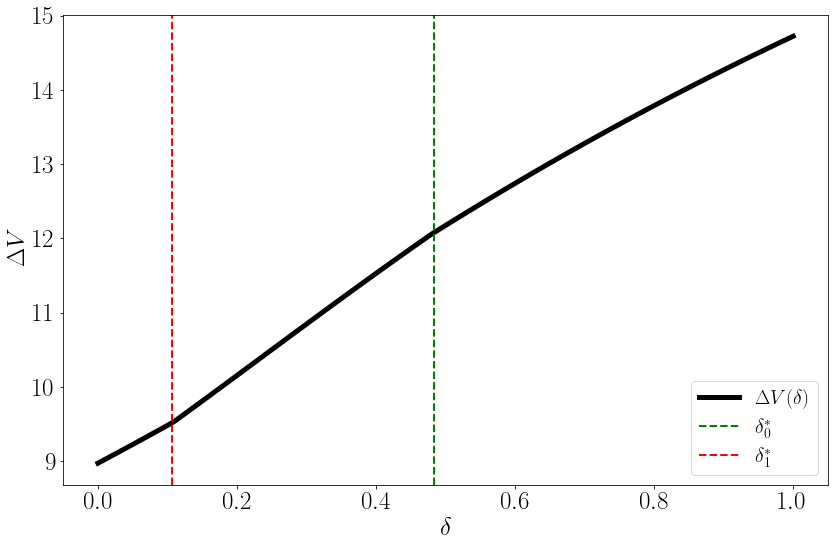

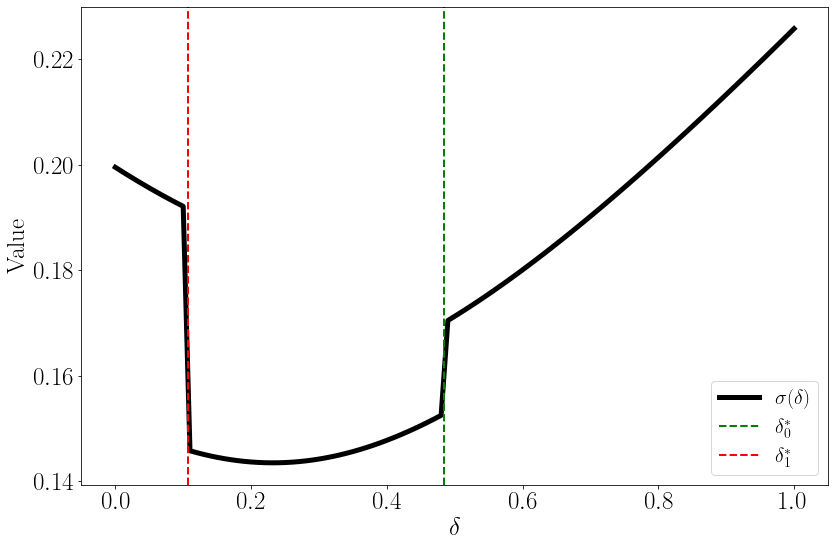

Minimum at 0.23


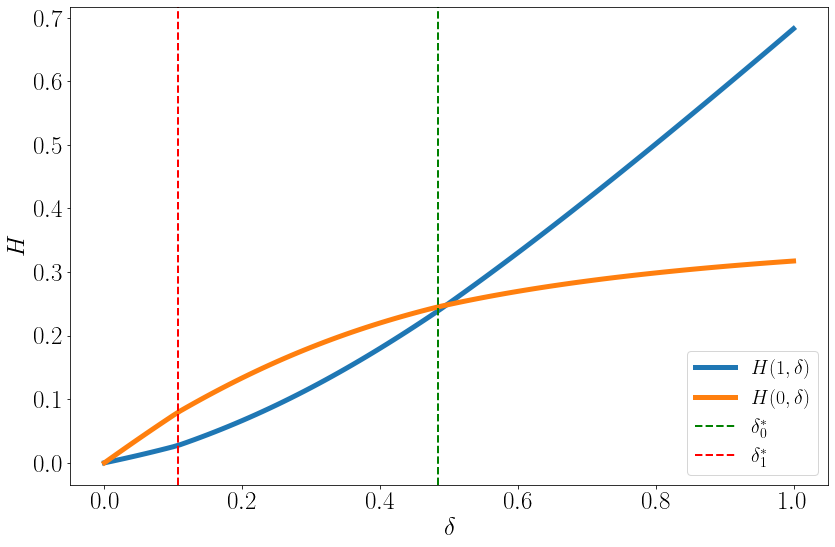

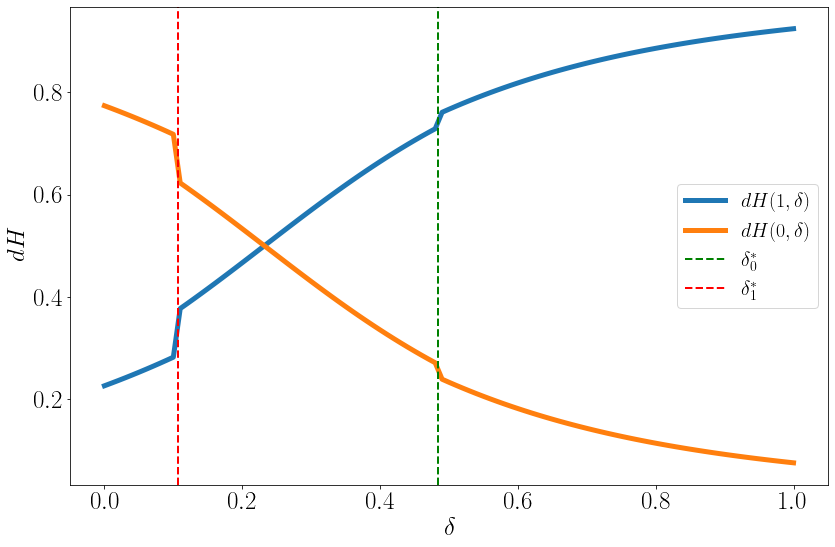

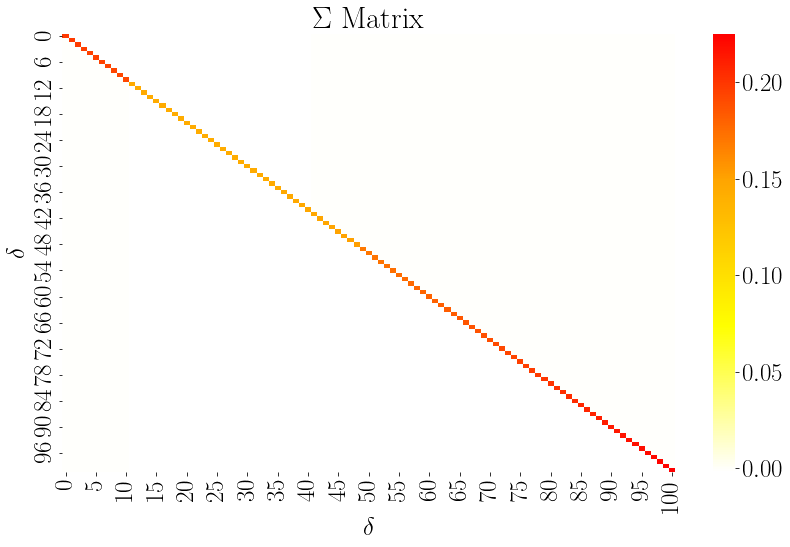

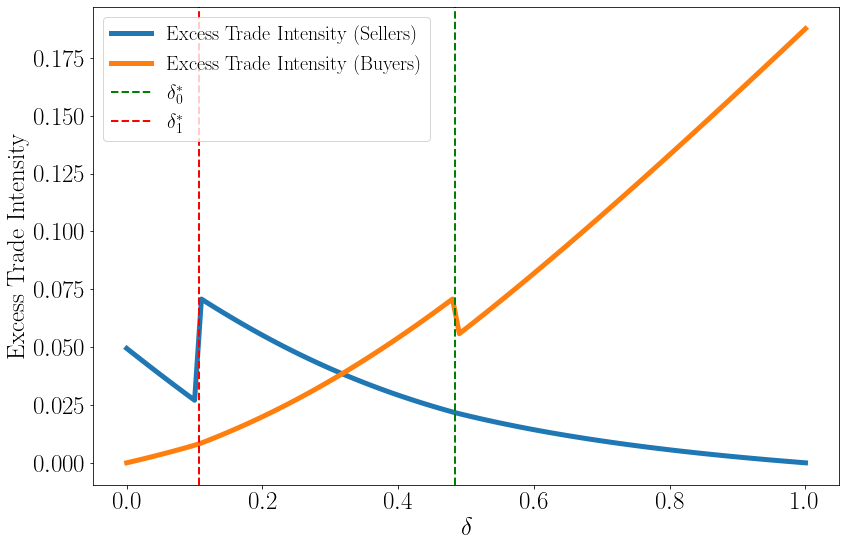

0.483672706 0.106481650304695


In [6]:
# Plot the value and dh functions
plot_value_dh_functions(optimal_delta_0_star, optimal_delta_1_star, r, gamma, s, f, lambda1, rho, delta_grid)

# Print the optimal values
print(optimal_delta_0_star, optimal_delta_1_star)


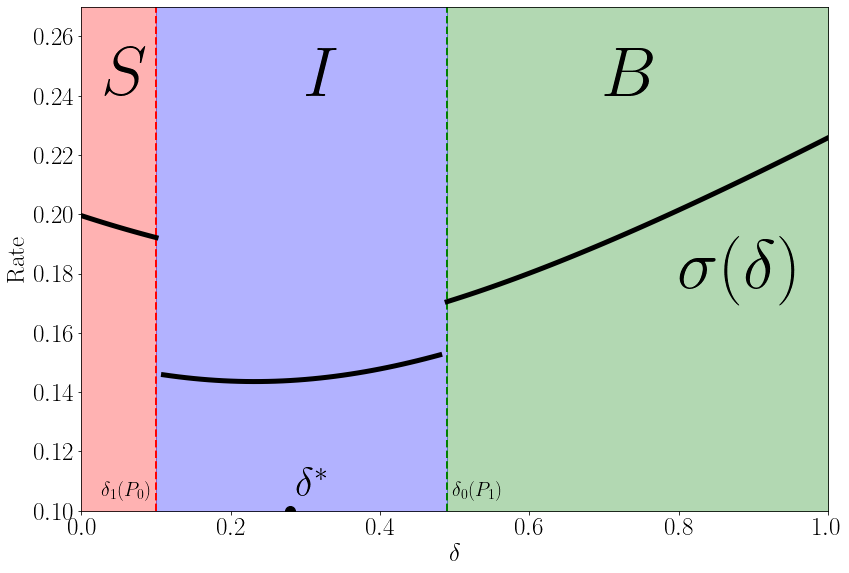

In [7]:

Sigma_matrix = Sigma(delta_grid, optimal_delta_0_star, optimal_delta_1_star, r, gamma, s, f, lambda1, rho)
optimal_delta_1_star_grid = delta_grid[np.abs(delta_grid - optimal_delta_1_star).argmin()-1]
optimal_delta_0_star_grid = delta_grid[np.abs(delta_grid - optimal_delta_0_star).argmin()+1]
    



delta_star = 1 - s
index_delta_star = np.abs(delta_grid - delta_star).argmin()

# Plot 5: Show only cutoffs and Sigma curve with label
# Find the indices corresponding to the closest grid points for optimal_delta_1_star and optimal_delta_0_star
index_delta_1_star = np.abs(delta_grid - optimal_delta_1_star_grid).argmin()
index_delta_0_star = np.abs(delta_grid - optimal_delta_0_star_grid).argmin()

# Split the delta_grid and Sigma values into three continuous parts
delta_grid_part1 = delta_grid[:index_delta_1_star+1]  # From 0 to before delta_1_star
delta_grid_part2 = delta_grid[index_delta_1_star+1:index_delta_0_star]  # Between delta_1_star and delta_0_star
delta_grid_part3 = delta_grid[index_delta_0_star:]  # From delta_0_star to 1

sigma_part1 = np.diag(Sigma_matrix)[:index_delta_1_star+1]
sigma_part2 = np.diag(Sigma_matrix)[index_delta_1_star+1:index_delta_0_star]
sigma_part3 = np.diag(Sigma_matrix)[index_delta_0_star:]

plt.figure(figsize=(12, 8))
#plt.plot(delta_grid, np.diag(Sigma_matrix), color='black', label='$\sigma(\delta)$',linewidth=5)


plt.axvline(x=optimal_delta_1_star_grid, color='red', linestyle='--', linewidth=2)
plt.axvline(x=optimal_delta_0_star_grid, color='green', linestyle='--', linewidth=2)
plt.fill_between(delta_grid, 0.1, 0.27, where=(delta_grid < optimal_delta_1_star), color='red', alpha=0.3)
plt.fill_between(delta_grid, 0.1, 0.27, where=(delta_grid > optimal_delta_0_star), color='green', alpha=0.3)
plt.fill_between(delta_grid, 0.1, 0.27, where=((delta_grid+0.01> optimal_delta_1_star) & (delta_grid-0.01 < optimal_delta_0_star)), color='blue', alpha=0.3)
plt.plot(delta_grid_part1, sigma_part1, color='black', linewidth=5)
plt.plot(delta_grid_part2, sigma_part2, color='black', linewidth=5)
plt.plot(delta_grid_part3, sigma_part3, color='black', linewidth=5)

plt.text(0.8, 0.175, '$\sigma(\delta)$', fontsize=70, color='black', fontweight='bold')
plt.text(0.03, 0.24, '$S$', fontsize=70, color='black', fontweight='bold')
plt.text(0.7, 0.24, '$B$', fontsize=70, color='black', fontweight='bold')
plt.text(0.3, 0.24, '$I$', fontsize=70, color='black', fontweight='bold')
plt.ylim(0.1, 0.27)
plt.xlim(0.0, 1.0)

plt.text(optimal_delta_1_star_grid-0.04, 0.1+ 0.005, r'$\delta_1(P_0)$', 
         fontsize=20, color='black', fontweight='bold', ha='center')
plt.text(optimal_delta_0_star_grid+0.04,0.1+ 0.005, r'$\delta_0(P_1)$', 
         fontsize=20, color='black', fontweight='bold', ha='center')
# Add violet dot at delta = 1 - s
plt.scatter(delta_grid[index_delta_star-3], 0.1, color='black', s=100, zorder=5)
plt.text(delta_grid[index_delta_star], 0.1+ 0.005, r'$\delta^*$', 
         fontsize=40, color='black', fontweight='bold', ha='center')


plt.tight_layout()
plt.xlabel('$\delta$')
plt.ylabel('Rate')

plt.show()


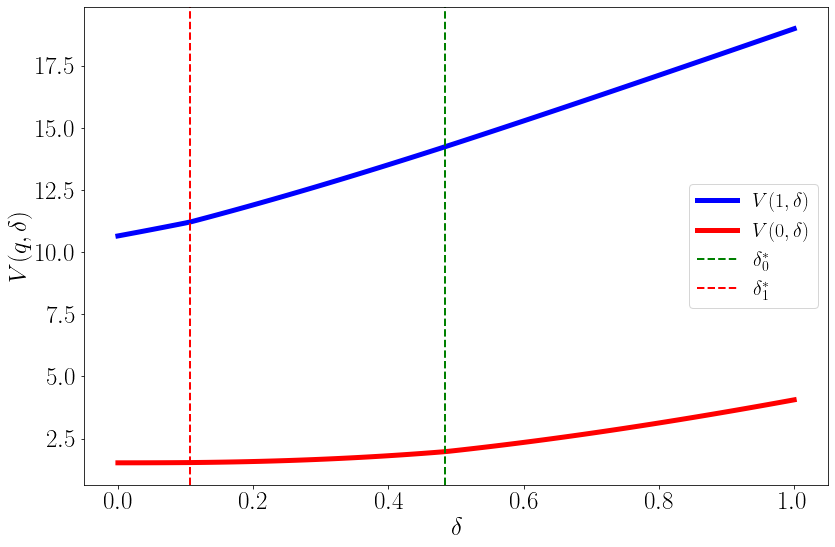

In [8]:
from scipy.integrate import simps
from scipy.interpolate import interp1d

# Define C(1, delta)
def C1(delta, r, gamma, s, f, lambda1, rho, Delta_V_interp, dH0_values, F0_value, delta_1_star, delta_grid):
    integrand_values = (Delta_V_interp(delta_grid) - Delta_V_interp(delta)) * dH0_values
    integrand_values[delta_grid < delta] = 0  # Enforce the integration bounds directly
    integral_term = (rho / 2) * simps(integrand_values, delta_grid)#np.sum(integrand_values) * (delta_grid[1] - delta_grid[0])
    
    max_term = lambda1 * F0_value * max(0, Delta_V_interp(delta_1_star) - Delta_V_interp(delta))
    
    return delta + integral_term + max_term

# Define C(0, delta)
def C0(delta, r, gamma, s, f, lambda1, rho, Delta_V_interp, dH1_values, F1_value, delta_0_star, delta_grid):
    integrand_values = -(Delta_V_interp(delta_grid) - Delta_V_interp(delta)) * dH1_values
    integrand_values[delta_grid > delta] = 0  # Enforce the integration bounds directly
    integral_term = (rho / 2) *simps(integrand_values, delta_grid)# np.sum(integrand_values) * (delta_grid[1] - delta_grid[0])
    
    max_term = lambda1 * F1_value * max(0, -(Delta_V_interp(delta_0_star) - Delta_V_interp(delta)))
    
    return integral_term + max_term

# Integrate C(q, delta') over [0, 1]
def integrate_C(C_values, delta_grid):
    delta_width = delta_grid[1] - delta_grid[0]  # Assuming uniform spacing
    return simps(C_values, delta_grid)#np.sum(C_values) * delta_width


# Compute V(q, delta) and V(0, delta)
def V_q(q, delta, r, gamma, s, f, lambda1, rho, delta_0_star, delta_1_star):
    F1_value = F1(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
    F0_value = f - F1_value
    # Compute H1_values and H0_values as arrays
    H1_values, H0_values = compute_H_values(delta_grid, delta_0_star, delta_1_star, 
                                            r, gamma, s, f, lambda1, rho)

    # Initialize dH0_values and dH1_values as arrays by using the _gen functions
    dH0_values = dH0_gen( delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
    dH1_values = dH1_gen( delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
    Delta_V, matrix_to_invert = value_iteration(delta_grid, delta_0_star, delta_1_star, 
                                                r, gamma, s, f, lambda1, rho)

    Delta_V_interp = interp1d(delta_grid, Delta_V, kind='linear', fill_value="extrapolate")

     
    if q == 1:
        C_q_delta = C1(delta, r, gamma, s, f, lambda1, rho, Delta_V_interp, dH0_values, F0_value, delta_1_star, delta_grid)
        C_values = [C1(d, r, gamma, s, f, lambda1, rho, Delta_V_interp, dH0_values, F0_value, delta_1_star, delta_grid) for d in delta_grid]
    else:
        C_q_delta = C0(delta, r, gamma, s, f, lambda1, rho, Delta_V_interp, dH1_values, F1_value, delta_0_star, delta_grid)
        C_values = [C0(d, r, gamma, s, f, lambda1, rho, Delta_V_interp, dH1_values, F1_value, delta_0_star, delta_grid) for d in delta_grid]
    
    C_integral = integrate_C(C_values, delta_grid)
    
    V_q_delta = (C_q_delta + (gamma / r) * C_integral) / (r + gamma)
    return V_q_delta
# Function to compute V1, V0, and Delta_V (theoretical)
def calculate_V1_V0(delta_grid, Delta_V_interp, params):
    V1_values = np.array([
        V_q(1, delta, params['r'], params['gamma'], params['s'], params['f'], params['lambda1'], params['rho'],
            params['optimal_delta_0_local'], params['optimal_delta_1_local'])
        for delta in delta_grid
    ])
    V0_values = np.array([
        V_q(0, delta, params['r'], params['gamma'], params['s'], params['f'], params['lambda1'], params['rho'],
            params['optimal_delta_0_local'], params['optimal_delta_1_local'])
        for delta in delta_grid
    ])
    return V1_values, V0_values

# Function to calculate the integrals and welfare
def calculate_welfare(V1_values, V0_values, dH1_values, dH0_values, delta_grid, F0_value, F1_value, W0_val, W1_val, params):
    intV1 = np.sum(V1_values * dH1_values)*grid_spacing#simps(V1_values * dH1_values, delta_grid)
    intV0 = np.sum(V0_values * dH0_values)*grid_spacing#simps(V0_values * dH0_values, delta_grid)
    welfare_agent = intV1 + intV0

    intW0 = W0_val * F0_value
    intW1 = W1_val * F1_value
    welfare_flipper = intW0 + intW1

    return intV1, intV0, welfare_agent, intW0, intW1, welfare_flipper

# Compute Delta V(delta) = V(1, delta) - V(0, delta)
def calculate_Delta_V(delta_grid, r, gamma, s, f, lambda1, rho, Delta_V_interp, dH0_values, dH1_values, F0_value, F1_value, delta_0_star, delta_1_star):
    V1_values = np.array([V_q(1, delta, r, gamma, s, f, lambda1, rho, delta_0_star, delta_1_star) for delta in delta_grid])
    V0_values = np.array([V_q(0, delta, r, gamma, s, f, lambda1, rho, delta_0_star, delta_1_star) for delta in delta_grid])
    return V1_values, V0_values, V1_values - V0_values

# Example of usage
def plot_V_q_and_Delta_V(delta_grid, Delta_V, Delta_V_interp, dH0_values, dH1_values, F0_value, F1_value, r, gamma, s, f, lambda1, rho, delta_0_star, delta_1_star):
    V1_values, V0_values, Delta_V_theoretical = calculate_Delta_V(delta_grid, r, gamma, s, f, lambda1, rho, Delta_V_interp, dH0_values, dH1_values, F0_value, F1_value, delta_0_star, delta_1_star)

    # Plot V(q, delta) for q = 1 and q = 0
    plt.figure(figsize=(12, 8))
    
    # Adjust the line width and colors to match the CDF plot style
    plt.plot(delta_grid, V1_values, label="$V(1, \delta)$", linewidth=5, color='blue')  # Adjust linewidth to 5
    plt.plot(delta_grid, V0_values, label="$V(0, \delta)$", linewidth=5, color='red')  # Adjust linewidth to 5
    
    # Adjust the vertical lines to match the CDF plot style
    plt.axvline(x=delta_0_star, color='green', linestyle='--', linewidth=2, label='$\delta_0^*$')  # Match linestyle and linewidth
    plt.axvline(x=delta_1_star, color='RED', linestyle='--', linewidth=2, label='$\delta_1^*$')  # Match linestyle and linewidth
    
    plt.xlabel(r"$\delta$")
    plt.ylabel(r"$V(q, \delta)$")
    
    # Optionally remove the title to match the CDF plot
    # plt.title("Comparison of $V(1, \delta)$ and $V(0, \delta)$")
    
    plt.legend()
    #plt.grid(True)  # Optionally leave out the grid to match the CDF plot style
    plt.tight_layout()

    plt.show()

F1_value = F1(optimal_delta_0_star, optimal_delta_1_star, r, gamma, s, f, lambda1, rho)
F0_value = f - F1_value
H1_values, H0_values = compute_H_values(delta_grid, optimal_delta_0_star, optimal_delta_1_star, r, gamma, s, f, lambda1, rho)

    # Initialize dH0_values and dH1_values as arrays by using the _gen functions
dH0_values = dH0_gen( optimal_delta_0_star, optimal_delta_1_star, r, gamma, s, f, lambda1, rho)
dH1_values = dH1_gen( optimal_delta_0_star, optimal_delta_1_star, r, gamma, s, f, lambda1, rho)
Delta_V, matrix_to_invert = value_iteration(delta_grid, optimal_delta_0_star, optimal_delta_1_star, r, gamma, s, f, lambda1, rho)

Delta_V_interp = interp1d(delta_grid, Delta_V, kind='linear', fill_value="extrapolate")

plot_V_q_and_Delta_V(delta_grid, Delta_V, Delta_V_interp, dH0_values, dH1_values, F0_value, F1_value, r, gamma, s, f, lambda1, rho, optimal_delta_0_star, optimal_delta_1_star)

In [9]:
# Trade of households over 2 years
def trade_hh_over2(r, gamma, s, f, lambda1, rho, dH0_values, dH1_values):
    # Indicator matrix for delta_prime >= delta
    Indicator_matrix = np.less_equal.outer(delta_grid, delta_grid).astype(float)
    
    # Compute the exp term over two years with grid spacing included
    exp_term = np.exp(-2 * rho * np.cumsum(dH1_values, axis=0) * grid_spacing)
    
    # Compute kappa1 over 2 years
    kappa_hh_over2 = rho * np.sum(dH1_values @ (Indicator_matrix * exp_term) @ dH0_values.T) * grid_spacing**2
    return kappa_hh_over2

# Trade of flippers under 2 years
def trade_flipper_under2(r, gamma, s, f, lambda1, rho, delta_0_star, delta_1_star):
    F0_value = F0(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
    F1_value=f-F0_value
    # Integral of dH1 up to delta_1_star
    #integral_dH1_delta1 = np.sum(dH1_values[delta_grid <= delta_1_star]) * grid_spacing
    #integral_dH0_delta0 = np.sum(dH0_values[delta_0_star  <= delta_grid]) * grid_spacing
    integral_dH1_delta1= H1(delta_1_star, delta_0_star, delta_1_star, F1(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho), r, gamma, s, f, lambda1, rho)
    integral_dH0_delta0= H0(delta_bar, delta_0_star, delta_1_star, F1(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho), r, gamma, s, f, lambda1, rho)-H0(delta_0_star, delta_0_star, delta_1_star, F1(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho), r, gamma, s, f, lambda1, rho)

    # Compute the exponential term
    exp_term_flippers1 = 1 - np.exp(-2 * lambda1 * integral_dH1_delta1)
    exp_term_flippers0 = 1 - np.exp(-2 * lambda1 * integral_dH0_delta0)
    # Compute kappa2 under 2 years
    kappa_flipper_under2 = lambda1 * (F0_value * integral_dH1_delta1 *exp_term_flippers0+F1_value * integral_dH0_delta0* exp_term_flippers1)
    return kappa_flipper_under2

# Example of how to compute total trade volume under and over 2 years
def trade_volume_2years(r, gamma, s, f, lambda1, rho, dH0_values, dH1_values, delta_0_star, delta_1_star):
    kappa_hh_over2 = trade_hh_over2(r, gamma, s, f, lambda1, rho, dH0_values, dH1_values)
    kappa_flipper_under2 = trade_flipper_under2(r, gamma, s, f, lambda1, rho, delta_0_star, delta_1_star)
    
    return kappa_hh_over2, kappa_flipper_under2


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Calculate trade volume among households (kappa1)
def trade_hh(r, gamma, s, f, lambda1, rho, dH0_values, dH1_values):
    # Indicator matrix for delta_prime >= delta
    Indicator_matrix = np.less_equal.outer(delta_grid, delta_grid).astype(float)
    
    # Compute kappa1 with grid spacing included
    kappa_13 = rho * np.sum(dH1_values @ Indicator_matrix @ dH0_values.T) * grid_spacing**2
    return kappa_13

# Calculate trade volume involving flippers (kappa2)
def trade_flipper(r, gamma, s, f, lambda1, rho, delta_0_star, delta_1_star):
    F0_value = F0(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
    #H1_delta1 = dH1(delta_1_star, delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
    H1_delta1 = H1(delta_1_star, delta_0_star, delta_1_star, F1(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho), r, gamma, s, f, lambda1, rho)

    # Compute kappa2
    kappa_23 = 2*lambda1 * F0_value * H1_delta1
    return kappa_23

# Compute total trade volume kappa
def trade_volume(r, gamma, s, f, lambda1, rho, dH0_values, dH1_values, delta_0_star, delta_1_star):
    kappa13 = trade_hh(r, gamma, s, f, lambda1, rho, dH0_values, dH1_values)
    kappa23 = trade_flipper(r, gamma, s, f, lambda1, rho, delta_0_star, delta_1_star)
    kappa3 = kappa13 + kappa23
    return kappa3, kappa13, kappa23

Trade Volume kappa: 0.017460152801046305, kappa1 (households): 0.014971568431986677, kappa2 (flippers): 0.00248858436905963
Computed Mean of P: 11.621838042455643
Computed Variance of P: 1.7963533474771665
Computed Skewness of P: -0.01316078041291763
P50/P10: 1.2326344483448182


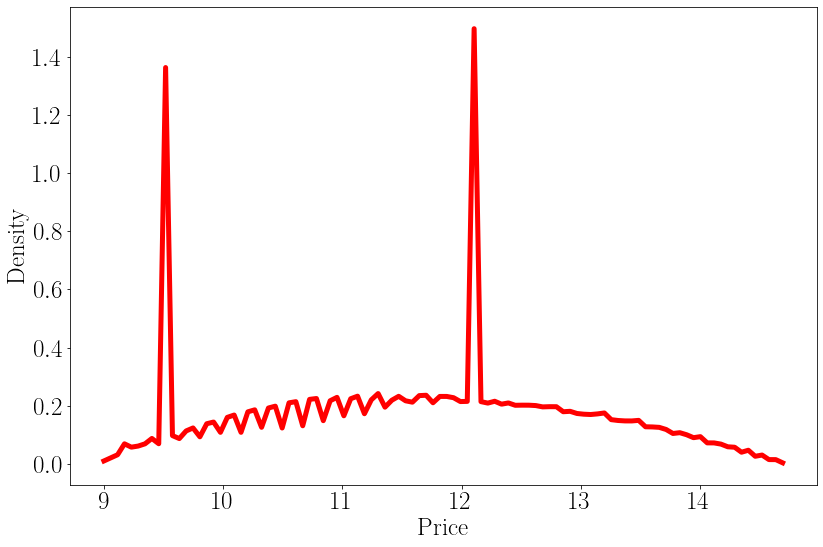

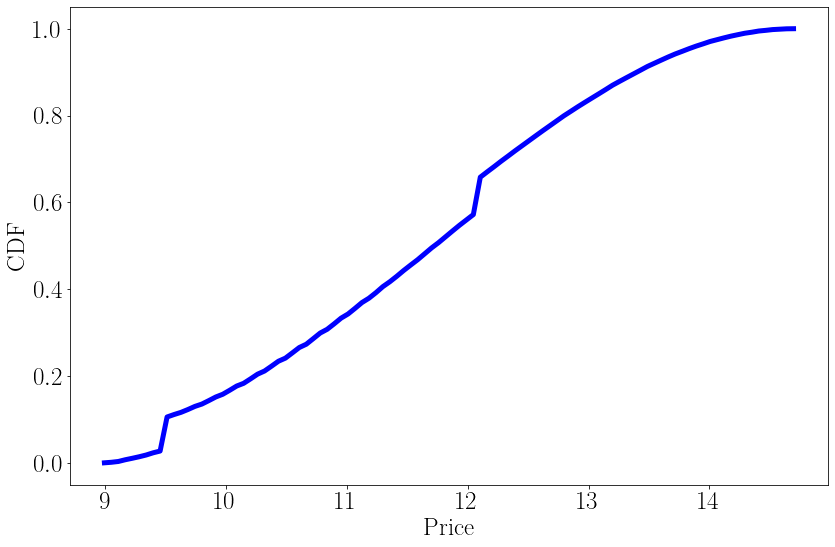

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Function to compute P_mean and P_variance
def compute_P_mean_variance(p_values, F_P):
    # Compute the PDF using finite differences
    delta_p = p_values[1] - p_values[0]
    f_P = np.diff(F_P) / np.diff(p_values)
    
    # Normalize the PDF
    f_P_sum = np.sum(f_P) * delta_p
    f_P = f_P / f_P_sum
    p_values_mid = (p_values[:-1] + p_values[1:]) / 2  # Midpoints for plotting PDF

    # Compute the mean and variance using the PDF
    P_mean = np.sum(p_values_mid * f_P) * delta_p
    P_variance = np.sum((p_values_mid - P_mean) ** 2 * f_P) * delta_p

    return P_mean, P_variance


# Function to compute skewness
def compute_skewness(p_values_mid, f_P, P_mean, P_variance):
    # Skewness is the third standardized moment
    delta_p = p_values_mid[1] - p_values_mid[0]
    P_skewness = np.sum(((p_values_mid - P_mean) ** 3) * f_P) * delta_p / (P_variance ** 1.5)
    return P_skewness

# Function to calculate percentiles
def compute_percentile(cdf_values, p_values, target):
    if target <= cdf_values[0]:
        return p_values[0]
    elif target >= cdf_values[-1]:
        return p_values[-1]
    else:
        return interp1d(cdf_values, p_values, fill_value="extrapolate")(target)

# Calculate price distribution (CDF)
def price_distribution(r, gamma, s, f, lambda1, rho, Delta_V_interp, 
                       dH0_values, dH1_values, kappa1, kappa2, 
                       delta_0_star, delta_1_star):

    F1_val = F1(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
    F0_val = f - F1_val
    # Define price grid
    p_values = np.linspace(np.min(Delta_V_interp(delta_grid)), np.max(Delta_V_interp(delta_grid)), len(delta_grid))
    
    # Create price matrix P(delta, delta_prime)
    P_matrix = np.array([[P(delta, delta_prime, Delta_V_interp) for delta_prime in delta_grid] for delta in delta_grid])
    
    # Initialize CDF array
    F_P = np.zeros(len(p_values))
    
    # Calculate the CDF
    for k, p in enumerate(p_values):
        # Indicator matrix for P(delta, delta_prime) <= p
        I_p = (P_matrix <= p).astype(float)
        
        # Apply both indicators 1_{\delta' > \delta} and 1_{P(\delta, \delta') <= p}
        I_delta_prime_greater_delta = np.triu(np.ones_like(P_matrix), 1)  # Upper triangular matrix to enforce \delta' > \delta
        I_combined = I_p  * I_delta_prime_greater_delta
        
        # Double integral for the CDF (first term)
        integral_double = grid_spacing**2 * np.sum(dH1_values @ I_combined @ dH0_values.T)
        
        # Marginal contributions from P0 and P1 (second and third terms)
        if P0(Delta_V_interp, delta_1_star) <= p:
            integral_P0 = kappa2/2

        else:
            integral_P0 = 0
        
        if P1(Delta_V_interp, delta_0_star) <= p:
            integral_P1 = kappa2/2
        else:
            integral_P1 = 0
        
        # Combine into CDF value, scaled by appropriate factors
        F_P[k] = (integral_double*rho+integral_P0+ integral_P1 )/(kappa1 +kappa2) 
    
    delta_p = p_values[1] - p_values[0]   
    
    # Normalize the CDF
    F_P_sum = np.sum(F_P) * delta_p
    F_P = F_P / F_P_sum
    return p_values, F_P


# Plot price distribution
def plot_price_distribution(p_values, F_P):
        # Compute the PDF using finite differences
    delta_p = p_values[1] - p_values[0]
    f_P = np.diff(F_P) / np.diff(p_values)
    
    # Normalize the PDF
    f_P_sum = np.sum(f_P) * delta_p
    f_P = f_P / f_P_sum
    p_values_mid = (p_values[:-1] + p_values[1:]) / 2  # Midpoints for plotting PDF

    # Compute the mean, variance, and skewness using the compute_P_mean_variance function
    P_mean, P_variance = compute_P_mean_variance(p_values, F_P)
    P_skewness = compute_skewness(p_values_mid, f_P, P_mean, P_variance)

    # Normalize the CDF
    cdf_values = np.cumsum(f_P) * (p_values_mid[1] - p_values_mid[0])
    
    # Calculate P80/P20 ratio
    p50 = compute_percentile(cdf_values, p_values_mid, 0.50)
    p10 = compute_percentile(cdf_values, p_values_mid, 0.10)
    P50_P10 = p50 / p10
    print(f"P50/P10: {P50_P10}")

    # Plot the PDF of prices
    plt.figure(figsize=(12, 8))
    plt.plot(p_values_mid, f_P, color='red', linewidth=5)
    plt.xlabel('Price')
    plt.ylabel('Density')
    #plt.title('PDF of Price Distribution')
    #plt.grid(True)
    plt.tight_layout()

    plt.show()

    # Plot the CDF of prices
    plt.figure(figsize=(12, 8))
    plt.plot(p_values_mid, cdf_values, color='blue', linewidth=5)
    plt.xlabel('Price')
    plt.ylabel('CDF')
    #plt.title('CDF of Price Distribution')
    #plt.grid(True)
    plt.tight_layout()

    plt.show()


# Example usage with the updated functions
# Assuming other necessary variables are already defined: delta_grid, optimal_delta_0_star, optimal_delta_1_star, etc.

# Running value iteration to get Delta_V
Delta_V, _ = value_iteration(delta_grid, optimal_delta_0_star, optimal_delta_1_star, r, gamma, s, f, lambda1, rho)

# Interpolating Delta_V
Delta_V_interp = interp1d(delta_grid, Delta_V, kind='linear', fill_value="extrapolate")

# Calculate dH0 and dH1 values
H_values = compute_H_values(delta_grid, optimal_delta_0_star, optimal_delta_1_star, r, gamma, s, f, lambda1, rho)
dH0_values = dH0_gen(optimal_delta_0_star, optimal_delta_1_star, r, gamma, s, f, lambda1, rho)
dH1_values = dH1_gen(optimal_delta_0_star, optimal_delta_1_star, r, gamma, s, f, lambda1, rho)

# Compute trade volumes
grid_spacing = delta_grid[1] - delta_grid[0]
kappa, kappa1, kappa2 = trade_volume(r, gamma, s, f, lambda1, rho, dH0_values, dH1_values, 
                                     optimal_delta_0_star, optimal_delta_1_star)
print(f"Trade Volume kappa: {kappa}, kappa1 (households): {kappa1}, kappa2 (flippers): {kappa2}")

# Calculate price distribution (CDF)
p_values, F_P = price_distribution(r, gamma, s, f, lambda1, rho, Delta_V_interp,dH0_values, dH1_values, kappa1, kappa2,optimal_delta_0_star, optimal_delta_1_star)
# Calculate PDF using finite differences
delta_p = p_values[1] - p_values[0]
f_P = np.diff(F_P) / np.diff(p_values)

# Normalize the PDF
f_P_sum = np.sum(f_P) * delta_p
f_P = f_P / f_P_sum
p_values_mid = (p_values[:-1] + p_values[1:]) / 2  # Midpoints for plotting PDF

# Compute mean, variance, and skewness
P_mean, P_variance= compute_P_mean_variance(p_values, F_P)
P_skewness = compute_skewness(p_values_mid, f_P, P_mean, P_variance)
print(f"Computed Mean of P: {P_mean}")
print(f"Computed Variance of P: {P_variance}")
print(f"Computed Skewness of P: {P_skewness}")

# Plot price distribution (PDF and CDF)
plot_price_distribution(p_values, F_P)


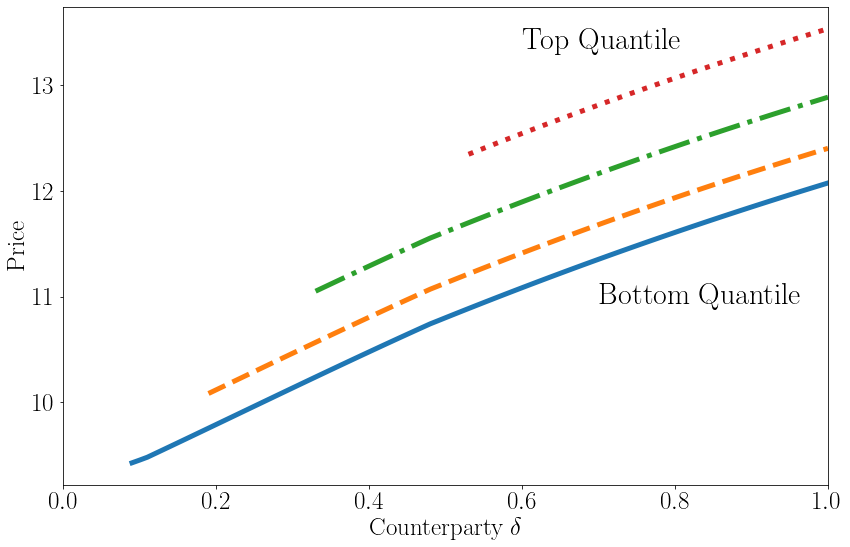

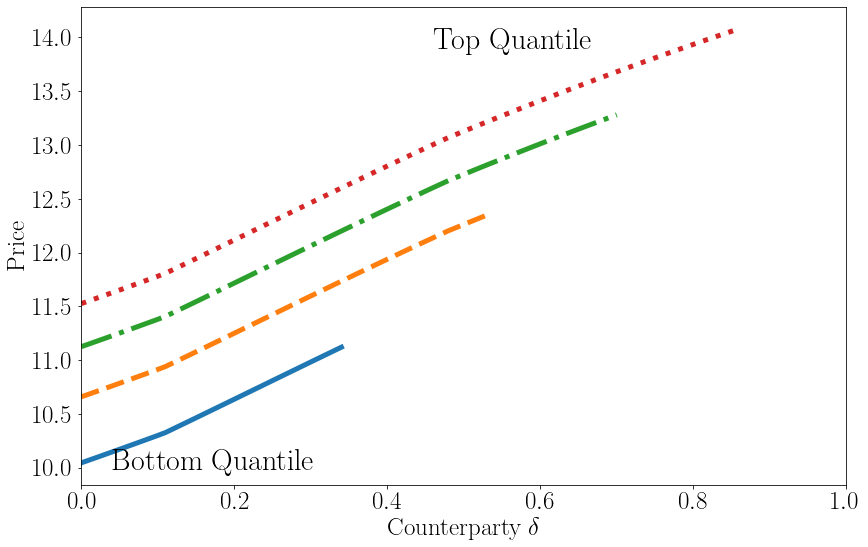

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

def plot_prices(delta_grid, optimal_delta_0_star, optimal_delta_1_star, r, gamma, s, f, lambda1, rho):
    """Plot prices for buyers and sellers with respect to different trade partners based on delta quantiles."""

    # Calculate the value function interpolation
    Delta_V, _ = value_iteration(delta_grid, optimal_delta_0_star, optimal_delta_1_star, r, gamma, s, f, lambda1, rho)
    Delta_V_interp = interp1d(delta_grid, Delta_V, kind='linear', fill_value="extrapolate")

    # Calculate F1 used in H0 and H1 functions
    F1_value = F1(optimal_delta_0_star, optimal_delta_1_star, r, gamma, s, f, lambda1, rho)
    
    # Calculate H0 and H1 values element-wise
    H0_values = np.array([H0(delta, optimal_delta_0_star, optimal_delta_1_star, F1_value, r, gamma, s, f, lambda1, rho) for delta in delta_grid])
    H1_values = np.array([H1(delta, optimal_delta_0_star, optimal_delta_1_star, F1_value, r, gamma, s, f, lambda1, rho) for delta in delta_grid])

    # Normalizing quantile points
    H0_max = H0(1.0, optimal_delta_0_star, optimal_delta_1_star, F1_value, r, gamma, s, f, lambda1, rho)
    H1_max = H1(1.0, optimal_delta_0_star, optimal_delta_1_star, F1_value, r, gamma, s, f, lambda1, rho)

    quantiles = [0.2, 0.4, 0.6, 0.8]
    
    # Calculate quantiles for buyers (non-owners)
    buyer_deltas_quantiles = [delta_grid[min(np.searchsorted(H0_values, q * H0_max), len(delta_grid) - 1)] for q in quantiles]
    # Calculate quantiles for sellers (owners)
    seller_deltas_quantiles = [delta_grid[min(np.searchsorted(H1_values, q * H1_max), len(delta_grid) - 1)] for q in quantiles]
    # Generate a range of counterparty deltas for plotting
    counterparty_deltas = delta_grid
    
    # Plot prices for buyers meeting different households
    plt.figure(figsize=(12, 8))
    for i, delta_buyer in enumerate(buyer_deltas_quantiles):
        # Only plot for delta values higher than the quantile
        idx_start = np.searchsorted(counterparty_deltas, delta_buyer)
        partial_counterparty_deltas = counterparty_deltas[idx_start:]
        prices = [0.5 * Delta_V_interp(delta_buyer) + 0.5 * Delta_V_interp(delta_seller) for delta_seller in partial_counterparty_deltas]
        plt.plot(partial_counterparty_deltas, prices, linewidth=5, linestyle=['-', '--', '-.', ':', (0, (3, 1, 1, 1))][i])
        # Add text annotations for the top and bottom quantiles
        if i == 0:
            plt.text(partial_counterparty_deltas[-1]-0.3, prices[-1]-1.2, 'Bottom Quantile', color='black', fontsize=30, verticalalignment='bottom')
        elif i == len(buyer_deltas_quantiles) - 1:
            plt.text(partial_counterparty_deltas[-1]-0.4, prices[-1], 'Top Quantile', color='black', fontsize=30, verticalalignment='top')

    plt.xlabel('Counterparty $\delta$')
    plt.ylabel('Price')
    plt.tight_layout()
    plt.xlim(0, 1)

    plt.show()
    
    # Plot prices for sellers meeting different households
    plt.figure(figsize=(12, 8))
    for i, delta_seller in enumerate(seller_deltas_quantiles):
        # Only plot for delta values lower than the quantile
        idx_end = np.searchsorted(counterparty_deltas, delta_seller, side='right')
        partial_counterparty_deltas = counterparty_deltas[:idx_end]
        
        prices = [0.5 * Delta_V_interp(delta_buyer) + 0.5 * Delta_V_interp(delta_seller) for delta_buyer in partial_counterparty_deltas]
        plt.plot(partial_counterparty_deltas, prices, linewidth=5, linestyle=['-', '--', '-.', ':', (0, (3, 1, 1, 1))][i])

        # Add text annotations for the top and bottom quantiles
        if i == 0:
            plt.text(partial_counterparty_deltas[-1]-0.3, prices[-1]-1.2, 'Bottom Quantile', color='black', fontsize=30, verticalalignment='bottom')
        elif i == len(seller_deltas_quantiles) - 1:
            plt.text(partial_counterparty_deltas[-1]-0.4, prices[-1], 'Top Quantile', color='black', fontsize=30, verticalalignment='top')

    plt.xlabel('Counterparty $\delta$')
    plt.ylabel('Price') 
    plt.tight_layout()
    plt.xlim(0, 1)

    plt.show()

# Call the function to plot
plot_prices(delta_grid, optimal_delta_0_star, optimal_delta_1_star, r, gamma, s, f, lambda1, rho)


## Simulation

In [13]:
from scipy.stats import skew
import pandas as pd
import statsmodels.api as sm
import numpy as np
from scipy.interpolate import interp1d
import time

def simulate_model2(delta_grid, optimal_delta_0_star, optimal_delta_1_star, r, gamma, s, f, lambda1, rho, T, N, dt):
    # Interpolation for value function
    Delta_V, _ = value_iteration(delta_grid, optimal_delta_0_star, optimal_delta_1_star, r, gamma, s, f, lambda1, rho)
    Delta_V_interp = interp1d(delta_grid, Delta_V, kind='linear', fill_value="extrapolate")

    # Initialize arrays to store statistics
    prices = []
    flipper_dummy = []
    household_trades = []
    flipper_trades = []

    # Household initialization
    ownership_status = np.random.binomial(1, s - F1(optimal_delta_0_star, optimal_delta_1_star, r, gamma, s, f, lambda1, rho), N)
    deltas = np.random.uniform(0, 1, N)
    
    # Flipper initialization
    num_flippers = int(N * f)
    flipper_ownership_status = np.random.binomial(1,
                                                  F1(optimal_delta_0_star, optimal_delta_1_star, 
                                                     r, gamma, s, f, lambda1, rho) * N / num_flippers, num_flippers)
    flipper_deltas = np.random.uniform(0, 1, num_flippers) #assign number to keep track
    
    # Determine total houses based on initial ownership
    total_houses = np.sum(ownership_status) + np.sum(flipper_ownership_status)
    
    # Create a mapping of agents (households and flippers) to houses
    current_house_ownership = {}  # Key: agent index, Value: house_id
    house_history = {house_id: [] for house_id in range(total_houses)}
    house_deltas = {house_id: [] for house_id in range(total_houses)}  # Track delta for each house
    ownership_indices = np.full((total_houses, int(T / dt)), -1)  # Track ownership indices over time
    house_id = 0

    # Assign houses to households
    for i in range(N):
        if ownership_status[i] == 1:
            current_house_ownership[i] = house_id
            house_history[house_id].append((0, 'household', deltas[i]))
            house_deltas[house_id].append(deltas[i])  # Store initial delta
            ownership_indices[house_id, 0] = i  # Track ownership index for the initial period
            house_id += 1

    # Assign houses to flippers
    for i in range(num_flippers):
        if flipper_ownership_status[i] == 1:
            current_house_ownership[N + i] = house_id  # N+i to differentiate flippers
            house_history[house_id].append((0, 'flipper', flipper_deltas[i]))
            house_deltas[house_id].append(flipper_deltas[i])  # Store initial delta for flipper
            ownership_indices[house_id, 0] = N + i  # Track ownership index for the initial period
            house_id += 1

    # Initialize history of agent interactions and flippers
    trade_history = []
    flipper_ownership_history = np.zeros((num_flippers, int(T/dt)))
    household_ownership_history = np.zeros((N, int(T/dt)))
    flipper_holding_durations = np.zeros((num_flippers, int(T/dt)))
    holding_durations = np.zeros((N, int(T/dt)))
    price_history = np.full((N, int(T/dt)), np.nan)
    delta_history = np.zeros((N, int(T/dt)))
    flipper_price_history = np.full((num_flippers, int(T/dt)), np.nan)

    # Generate distributions for trades
    dH0_values = dH0_gen(optimal_delta_0_star, optimal_delta_1_star, r, gamma, s, f, lambda1, rho)
    dH1_values = dH1_gen(optimal_delta_0_star, optimal_delta_1_star, r, gamma, s, f, lambda1, rho)
    dH0_normalized = dH0_values / np.sum(dH0_values)
    dH1_normalized = dH1_values / np.sum(dH1_values)

    # Discretized total steps for dt
    total_steps = int(T / dt)
    
    # Run simulation over discrete time steps
    for step in range(total_steps):
        new_ownership_status = ownership_status.copy()
        new_flipper_ownership_status = flipper_ownership_status.copy()
        new_deltas = deltas.copy()
        period_prices = []
        num_household_trades = 0
        num_flipper_trades = 0

        # Iterate over households
        for i in range(N):
            random_val = np.random.uniform(0, 1)
        
            if ownership_status[i] == 0:  # Non-owner household
                # Draw delta_prime from CDF of owners H1
                delta_prime = np.random.choice(delta_grid, p=dH1_normalized)
                
                # Ensure trade happens only if delta_prime > delta[i]
                if delta_prime < deltas[i]:
                    prob_meet_household = rho * dt
                else:
                    prob_meet_household = 0

                # Draw a flipper with the opposite asset position
                eligible_flippers = np.where(flipper_ownership_status == 1)[0]
                if deltas[i] > optimal_delta_0_star and len(eligible_flippers) > 0:
                    flipper_index = np.random.choice(eligible_flippers)
                    prob_meet_flipper = lambda1 * dt * F1(optimal_delta_0_star, optimal_delta_1_star, r, gamma, s, f, lambda1, rho)
                else:
                    prob_meet_flipper = 0

                # Shock to delta
                prob_shock = gamma * dt

                # Determine event
                if random_val < prob_meet_household:
                    # Meet household
                    seller_index = np.argmin(np.abs(deltas - delta_prime))
                    if seller_index in current_house_ownership:
                        price = P(deltas[i], delta_prime, Delta_V_interp)
                        period_prices.append(price)
                        flipper_dummy.append(0)
                        new_ownership_status[i] = 1
                        new_ownership_status[seller_index] = 0
                        num_household_trades += 1
                        trade_history.append((step, i, seller_index, 'household'))
                        
                        # Update house history
                        house_id = current_house_ownership.pop(seller_index)
                        current_house_ownership[i] = house_id
                        house_history[house_id].append((step, 'household', deltas[i]))
                        house_deltas[house_id].append(deltas[i])  # Update house delta to new owner's delta
                        
                        # Update ownership indices
                        ownership_indices[house_id, step] = i  # Update ownership index for the current period

                elif random_val < (prob_meet_household + prob_meet_flipper):
                    # Meet flipper
                    flipper_agent_index = N + flipper_index
                    if flipper_agent_index in current_house_ownership:
                        price = P1(Delta_V_interp, optimal_delta_0_star)
                        period_prices.append(price)
                        flipper_dummy.append(1)
                        new_ownership_status[i] = 1
                        new_flipper_ownership_status[flipper_index] = 0
                        num_flipper_trades += 1
                        trade_history.append((step, i, flipper_agent_index, 'flipper'))

                        # Update house history
                        house_id = current_house_ownership.pop(flipper_agent_index)
                        current_house_ownership[i] = house_id
                        house_history[house_id].append((step, 'household', deltas[i]))
                        house_deltas[house_id].append(0)  # Mark delta as 0 for flipper

                        # Update ownership indices
                        ownership_indices[house_id, step] = flipper_agent_index  # Update ownership index for the current period

                elif random_val < (prob_meet_household + prob_meet_flipper + prob_shock):
                    # Shock occurs
                    new_deltas[i] = np.random.uniform(0, 1)

            elif ownership_status[i] == 1:  # Owner household
                delta_prime = np.random.choice(delta_grid, p=dH0_normalized)

                if delta_prime > deltas[i]:
                    prob_sell_household = rho * dt
                else:
                    prob_sell_household = 0

                # Draw a flipper with the opposite asset position
                eligible_flippers = np.where(flipper_ownership_status == 0)[0]
                if deltas[i] < optimal_delta_1_star and len(eligible_flippers) > 0:
                    flipper_index = np.random.choice(eligible_flippers)
                    prob_sell_flipper = lambda1 * dt * F0(optimal_delta_0_star, optimal_delta_1_star, r, gamma, s, f, lambda1, rho)
                else:
                    prob_sell_flipper = 0

                # Shock to delta
                prob_shock = gamma * dt

                # Determine event
                if random_val < prob_sell_household:
                    # Sell to household
                    buyer_index = np.argmin(np.abs(deltas - delta_prime))
                    if i in current_house_ownership and buyer_index not in current_house_ownership:
                        price = P(delta_prime, deltas[i], Delta_V_interp)
                        period_prices.append(price)
                        flipper_dummy.append(0)
                        new_ownership_status[i] = 0
                        new_ownership_status[buyer_index] = 1
                        num_household_trades += 1
                        trade_history.append((step, buyer_index, i, 'household'))
                        
                        # Update house history
                        house_id = current_house_ownership.pop(i)
                        current_house_ownership[buyer_index] = house_id
                        house_history[house_id].append((step, 'household', deltas[buyer_index]))
                        house_deltas[house_id].append(deltas[buyer_index])  # Update house delta to new owner's delta

                        # Update ownership indices
                        ownership_indices[house_id, step] = buyer_index  # Update ownership index for the current period

                elif random_val < (prob_sell_household + prob_sell_flipper):
                    # Sell to flipper
                    flipper_agent_index = N + flipper_index
                    if i in current_house_ownership and flipper_agent_index not in current_house_ownership:
                        price = P0(Delta_V_interp, optimal_delta_1_star)
                        period_prices.append(price)
                        flipper_dummy.append(1)
                        new_ownership_status[i] = 0
                        new_flipper_ownership_status[flipper_index] = 1
                        num_flipper_trades += 1
                        trade_history.append((step, flipper_agent_index, i, 'flipper'))

                        # Update house history
                        house_id = current_house_ownership.pop(i)
                        current_house_ownership[flipper_agent_index] = house_id
                        house_history[house_id].append((step, flipper_deltas[flipper_index]))
                        house_deltas[house_id].append(0)  # Mark delta as 0 for flipper

                        # Update ownership indices
                        ownership_indices[house_id, step] = flipper_agent_index  # Update ownership index for the current period

                elif random_val < (prob_sell_household + prob_sell_flipper + prob_shock):
                    # Shock occurs
                    new_deltas[i] = np.random.uniform(0, 1)

        # Ensure previous holding duration is carried over and updated
        if step > 0:
            
            holding_durations[:, step] = holding_durations[:, step - 1]
            
        else:
            
            holding_durations[:, step] = 0
            

        # Update holding duration based on ownership status
        for i in range(N):
            if new_ownership_status[i] == 1:
                holding_durations[i, step] += 1  # Increment duration if owning
            else:
                holding_durations[i, step] = 0  # Reset to 0 if not owning
       # Update holding durations for flippers
        if step > 0:
            flipper_holding_durations[:, step] = flipper_holding_durations[:, step - 1]  # Carry over flipper holding durations
        else:
            flipper_holding_durations[:, step] = 0  # Initialize for the first step

        # Update holding duration based on ownership status for flippers
        for flipper_index in range(num_flippers):
            if new_flipper_ownership_status[flipper_index] == 1:  # If flipper is owning
                flipper_holding_durations[flipper_index, step] += 1  # Increment duration if owning
            else:
                flipper_holding_durations[flipper_index, step] = 0  # Reset to 0 if not owning


        # Update statuses and histories
        flipper_ownership_status = new_flipper_ownership_status
        ownership_status = new_ownership_status
        deltas = new_deltas
        prices.extend(period_prices)
        # Store histories
        flipper_ownership_history[:, step] = flipper_ownership_status
        household_ownership_history[:, step] = ownership_status
        price_history[:, step] = np.pad(period_prices, (0, N - len(period_prices)), constant_values=np.nan)
        delta_history[:, step] = deltas

    # Calculate statistics across all agents and periods
    overall_average_price = np.mean(prices)
    price_variance = np.var(prices)
    price_skewness = skew(prices)
    percentile_80_20 = np.percentile(prices, 80) / np.percentile(prices, 20)

    # Regression: price on flipper dummy
    X = sm.add_constant(flipper_dummy)
    y = prices
    model = sm.OLS(y, X).fit()

    flipper_coeff = model.params[1]
    r_squared = model.rsquared

    return (price_history, delta_history, household_ownership_history, flipper_ownership_history, 
            holding_durations, flipper_holding_durations, trade_history, house_history, 
            house_deltas, ownership_indices,  # Return the ownership indices
            overall_average_price, price_variance, price_skewness, percentile_80_20, 
            flipper_coeff, r_squared)


In [14]:
# Simulation parameters
T = 100  # Number of periods
N = 10000  # Number of households
dt = 0.1  # Discretization time step

# Run the simulation
start_time = time.time()
np.random.seed(42) 
results = simulate_model2(delta_grid, optimal_delta_0_star, optimal_delta_1_star, r, gamma, s, f, lambda1, rho, T, N, dt)

# Unpack results
(price_history, delta_history, household_ownership_history, flipper_ownership_history, 
holding_durations, flipper_holding_durations, trade_history, house_history, 
house_deltas,ownership_indices,  # Return the house deltas
overall_average_price, price_variance, price_skewness, percentile_80_20, 
flipper_coeff, r_squared) = results

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Total time for simulation: {elapsed_time:.2f} seconds")

Total time for simulation: 541.18 seconds


In [15]:
# Display key results

print("Overall Average Price:", overall_average_price)
print("Price Variance:", price_variance)
print("Price Skewness:", price_skewness)
print("80/20 Percentile Ratio:", percentile_80_20)

print("Flipper Coefficient:", flipper_coeff)
print("R-squared:", r_squared)


# Displaying some additional moments or statistics
# Example: Display the number of trades and breakdown
num_trades = len(trade_history)
num_household_trades = sum(1 for trade in trade_history if trade[3] == 'household')
num_flipper_trades = sum(1 for trade in trade_history if trade[3] == 'flipper')

print(f"\nTotal Trades: {num_trades}")
print(f"Household-to-Household Trades: {num_household_trades}")
print(f"Household-to-Flipper Trades: {num_flipper_trades}")

# Example: Average holding duration for households and flippers
avg_holding_duration_households = np.mean(holding_durations[holding_durations > 0])
avg_holding_duration_flippers = np.mean(flipper_holding_durations[flipper_holding_durations > 0])

print(f"\nAverage Holding Duration (Households): {avg_holding_duration_households:.2f} periods")
print(f"Average Holding Duration (Flippers): {avg_holding_duration_flippers:.2f} periods")

# Example: Display a sample of house ownership history for the first 5 houses
print("\nSample of House Ownership History:")
for house_id in range(min(5, len(house_history))):
    print(f"House {house_id}: {house_history[house_id]}")


Overall Average Price: 11.527674296111792
Price Variance: 1.799776766655955
Price Skewness: 0.09114071325522762
80/20 Percentile Ratio: 1.2544466015412508
Flipper Coefficient: -0.7979884333369354
R-squared: 0.030267420365979847

Total Trades: 24272
Household-to-Household Trades: 21979
Household-to-Flipper Trades: 2293

Average Holding Duration (Households): 294.55 periods
Average Holding Duration (Flippers): 41.86 periods

Sample of House Ownership History:
House 0: [(0, 'household', 0.3736408184666985), (51, 'household', 0.40997972588656684), (53, 'household', 0.8080147490627835), (351, 'household', 0.40000813653002987), (351, 'household', 0.4174260567443111), (369, 'household', 0.7500459631700099), (377, 'household', 0.8764289069608965), (832, 'household', 0.8200442485153019), (936, 'household', 0.2399611179619977), (942, 'household', 0.8583459906736501)]
House 1: [(0, 'household', 0.6072666701014879), (160, 'household', 0.3499696306699761), (160, 'household', 0.5552709698512045)]
Ho

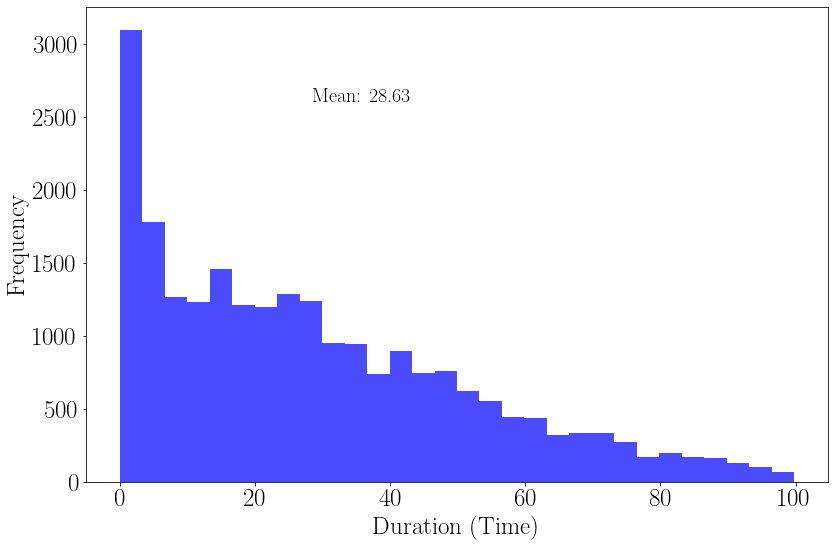

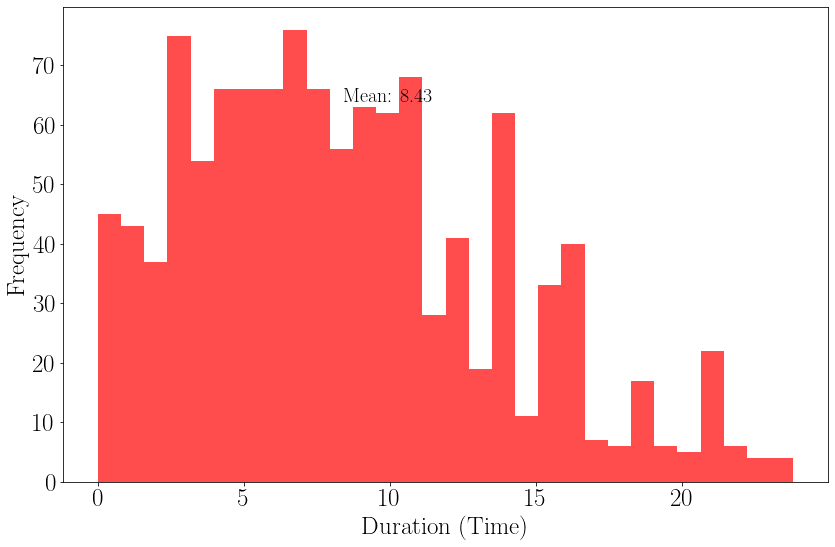

Mean Household Ownership Duration: 28.627160654035816
Variance Household Ownership Duration: 539.8467538638866
Mean Flipper Ownership Duration: 8.434315424610052
Variance Flipper Ownership Duration: 27.378406507093107


In [16]:
import numpy as np
import matplotlib.pyplot as plt

def plot_tenure_duration_histograms(household_ownership_history, trade_history, holding_durations, flipper_holding_durations, N, T, dt):
    household_ownership_durations = []
    flipper_ownership_durations = []
    household_non_ownership_durations = []
    flipper_non_ownership_durations = []

    for trade in trade_history:
        time, buyer_index, seller_index, _ = trade

        # Check if seller is a household or flipper and get their ownership duration
        if seller_index is not None:
            if seller_index < N:  # Household
                if time > 0:
                    owner_duration = np.max(holding_durations[seller_index, :time]) * dt
                else:
                    owner_duration = 0
                household_ownership_durations.append(owner_duration)

            else:  # Flipper
                flipper_idx = seller_index - N
                if time > 0:
                    owner_duration = np.max(flipper_holding_durations[flipper_idx, :time]) * dt
                else:
                    owner_duration = 0
                flipper_ownership_durations.append(owner_duration)

        # Check if buyer is a household or flipper and get their non-ownership duration
        if buyer_index is not None:
            if buyer_index < N:  # Household
                if time > 0:
                    non_owner_duration = np.max(holding_durations[buyer_index, :time]) * dt
                else:
                    non_owner_duration = 0
                household_non_ownership_durations.append(non_owner_duration)

            else:  # Flipper
                flipper_idx = buyer_index - N
                if time > 0:
                    non_owner_duration = np.max(flipper_holding_durations[flipper_idx, :time]) * dt
                else:
                    non_owner_duration = 0
                flipper_non_ownership_durations.append(non_owner_duration)

    # Plot household ownership duration histogram
    plt.figure(figsize=(12, 8))
    plt.hist(household_ownership_durations, bins=30, color='blue', alpha=0.7)
    plt.xlabel('Duration (Time)')
    plt.ylabel('Frequency')
    #plt.title('Household Ownership Duration Distribution')
    #plt.legend()
    plt.text(np.mean(household_ownership_durations), plt.ylim()[1] * 0.8, f"Mean: {np.mean(household_ownership_durations):.2f}", fontsize=20, color='black')
    plt.tight_layout()
    plt.show()

    # Plot flipper ownership duration histogram
    plt.figure(figsize=(12, 8))
    plt.hist(flipper_ownership_durations, bins=30, color='red', alpha=0.7)
    plt.xlabel('Duration (Time)')
    plt.ylabel('Frequency')
    #plt.title('Flipper Ownership Duration Distribution')
    #plt.legend()
    plt.text(np.mean(flipper_ownership_durations), plt.ylim()[1] * 0.8, f"Mean: {np.mean(flipper_ownership_durations):.2f}", fontsize=20, color='black')
    plt.tight_layout()
    plt.show()

    # Print means and variances
    print('Mean Household Ownership Duration:', np.mean(household_ownership_durations))
    print('Variance Household Ownership Duration:', np.var(household_ownership_durations))
    print('Mean Flipper Ownership Duration:', np.mean(flipper_ownership_durations))
    print('Variance Flipper Ownership Duration:', np.var(flipper_ownership_durations))

# Example usage
plot_tenure_duration_histograms(household_ownership_history, trade_history, holding_durations, flipper_holding_durations, N, T, dt)


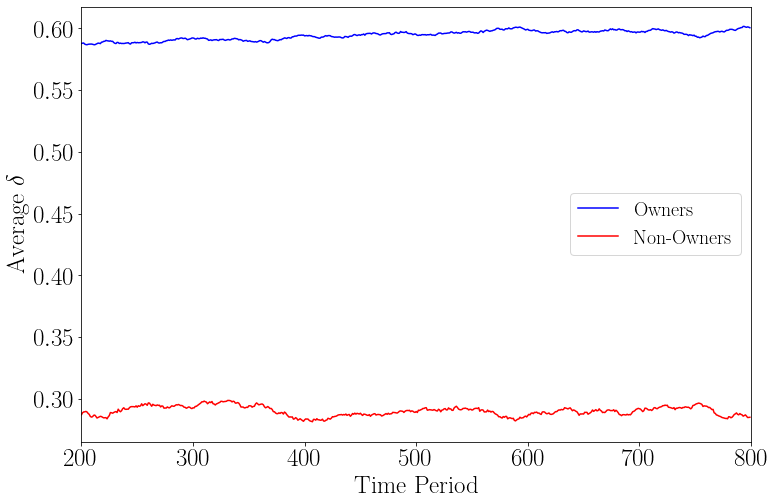

[1.45808414e-05 5.87521113e-01] [-4.49856277e-06  2.92476243e-01]


In [18]:
import numpy as np
import matplotlib.pyplot as plt

def plot_average_delta_owners_nonowners(delta_history, ownership_history, T, dt):
    """Plot average delta levels for owners and non-owners over time and fit linear trend lines."""

    # Burn-in period if necessary (modify as needed)
    burn_in = int(0.2 * T/dt)

    # Initialize lists to store average deltas for owners and non-owners
    avg_delta_owners = []
    avg_delta_nonowners = []

    # Calculate average delta for each period after burn-in
    for t in range(burn_in, delta_history.shape[1]):
        owners_delta = delta_history[ownership_history[:, t] == 1, t]
        nonowners_delta = delta_history[ownership_history[:, t] == 0, t]

        avg_delta_owners.append(np.nanmean(owners_delta) if len(owners_delta) > 0 else np.nan)
        avg_delta_nonowners.append(np.nanmean(nonowners_delta) if len(nonowners_delta) > 0 else np.nan)

    # Ensure both lists have the same length
    min_length = min(len(avg_delta_owners), len(avg_delta_nonowners))
    avg_delta_owners = avg_delta_owners[:min_length]
    avg_delta_nonowners = avg_delta_nonowners[:min_length]

    # Filter out NaN values before fitting trendlines
    periods = np.arange(min_length)
    owners_valid = np.isfinite(avg_delta_owners)
    nonowners_valid = np.isfinite(avg_delta_nonowners)

    # Fit linear trends only on valid data points
    if np.any(owners_valid):
        owners_coefficients = np.polyfit(periods[owners_valid], np.array(avg_delta_owners)[owners_valid], 1)
        owners_trend = np.polyval(owners_coefficients, periods)
    else:
        owners_coefficients, owners_trend = [np.nan, np.nan], np.full_like(periods, np.nan)

    if np.any(nonowners_valid):
        nonowners_coefficients = np.polyfit(periods[nonowners_valid], np.array(avg_delta_nonowners)[nonowners_valid], 1)
        nonowners_trend = np.polyval(nonowners_coefficients, periods)
    else:
        nonowners_coefficients, nonowners_trend = [np.nan, np.nan], np.full_like(periods, np.nan)

    # Define integer time steps (marks at t = 0, 1, 2, ..., T) and convert to indices
    mark_positions = np.arange(0, T + 1)  # Integer positions (0, 1, 2, ..., T)
    mark_indices = (mark_positions * (1/dt)).astype(int)  # Convert to indices for T/dt observations

    # Plot the average delta levels
    plt.figure(figsize=(12, 8))
    plt.plot(periods, avg_delta_owners, color='blue', linestyle='-', label="Owners")
    plt.plot(periods, avg_delta_nonowners, color='red', linestyle='-', label="Non-Owners")


    plt.xlabel('Time Period')
    plt.ylabel('Average $\delta$')
    plt.legend()
    plt.xlim(burn_in, T/dt-burn_in)


    plt.show()

    print(owners_coefficients, nonowners_coefficients)
# Run the plotting function
plot_average_delta_owners_nonowners(delta_history, household_ownership_history, T,dt)


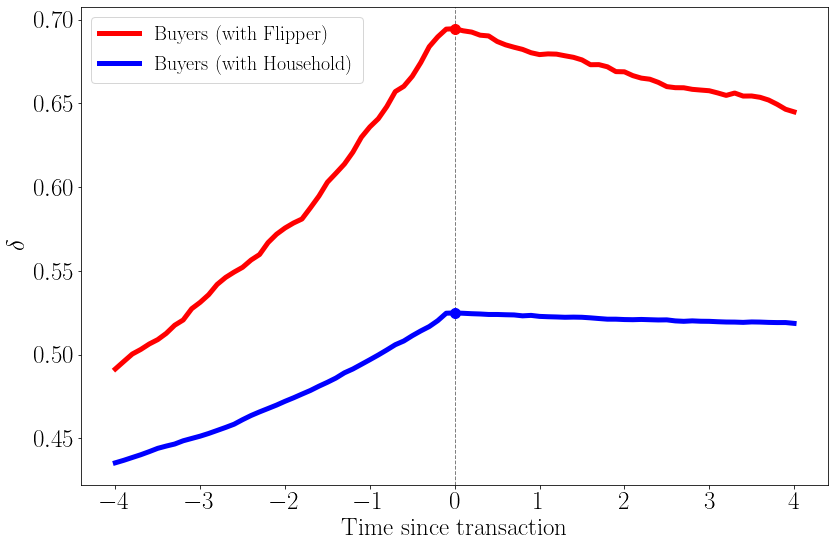

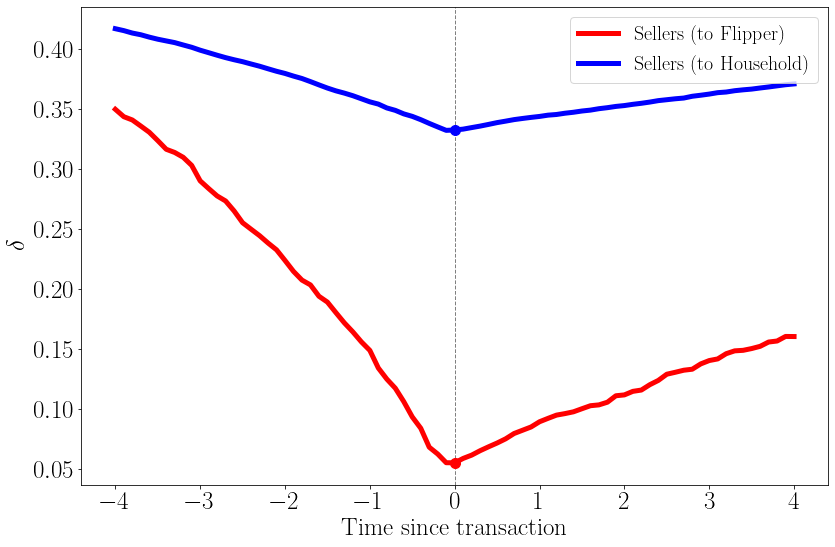

Mean Buyer Delta (with Flipper): 0.6945789741165395
Mean Buyer Delta (with Household): 0.524877978394213
Mean Seller Delta (to Flipper): 0.05507173370269476
Mean Seller Delta (to Household): 0.33257100548850743


In [19]:
import matplotlib.pyplot as plt
import numpy as np

def plot_delta_history_full(delta_history, trade_history, T, dt, time_window=4):
    """Plot average levels of delta at time t when transactions happen, tracing their levels of delta at t-3/dt, ..., t+3/dt."""
    
    # Determine the range of t to consider around each trade event
    delta_steps = int(time_window / dt)  # Steps around each trade event
    delta_range = np.arange(-delta_steps, delta_steps + 1)

    # Initialize dictionaries to track deltas based on trade type
    flipper_buyer_deltas = {k: [] for k in delta_range}
    household_buyer_deltas = {k: [] for k in delta_range}
    flipper_seller_deltas = {k: [] for k in delta_range}
    household_seller_deltas = {k: [] for k in delta_range}

    # Adjust burn-in period based on original T and delta_history's length
    burn_in = 0*int(0.2 * T)
    T_adjusted = delta_history.shape[1]

    for (t, buyer_index, seller_index, trade_type) in trade_history:
        # Adjust time index for burn-in period
        t_adjusted = t - burn_in

        # Ensure that we're within the bounds of delta_history
        if 0 <= t_adjusted < T_adjusted:
            for k in delta_range:
                adjusted_time = t_adjusted + k
                if 0 <= adjusted_time < T_adjusted:
                    if trade_type == 'flipper':
                        # Trades with flippers
                        if buyer_index is not None and buyer_index < delta_history.shape[0]:
                            flipper_buyer_deltas[k].append(delta_history[buyer_index, adjusted_time])
                        if seller_index is not None and seller_index < delta_history.shape[0]:
                            flipper_seller_deltas[k].append(delta_history[seller_index, adjusted_time])
                    elif trade_type == 'household':
                        # Trades with other households
                        if buyer_index is not None and buyer_index < delta_history.shape[0]:
                            household_buyer_deltas[k].append(delta_history[buyer_index, adjusted_time])
                        if seller_index is not None and seller_index < delta_history.shape[0]:
                            household_seller_deltas[k].append(delta_history[seller_index, adjusted_time])

    # Calculate average deltas for each time offset for flippers and households
    avg_flipper_buyer_deltas = [np.nanmean(flipper_buyer_deltas[k]) for k in delta_range]
    avg_flipper_seller_deltas = [np.nanmean(flipper_seller_deltas[k]) for k in delta_range]
    avg_household_buyer_deltas = [np.nanmean(household_buyer_deltas[k]) for k in delta_range]
    avg_household_seller_deltas = [np.nanmean(household_seller_deltas[k]) for k in delta_range]

    # Time range for plotting
    time_axis = delta_range * dt

    # Plot average delta levels for buyers (with flippers and with households)
    plt.figure(figsize=(12, 8))
    plt.plot(time_axis, avg_flipper_buyer_deltas, linewidth=5, color='red', label='Buyers (with Flipper)')
    plt.plot(time_axis, avg_household_buyer_deltas, linewidth=5, color='blue', label='Buyers (with Household)')

    # Highlight t=0 (transaction time)
    plt.axvline(x=0, color='gray', linestyle='--', linewidth=1)
    plt.scatter(0, avg_flipper_buyer_deltas[delta_steps], color='red', s=100, zorder=5)
    plt.scatter(0, avg_household_buyer_deltas[delta_steps], color='blue', s=100, zorder=5)
    
    plt.xlabel('Time since transaction')
    plt.ylabel('$\delta$')
    #plt.title('Average Delta Levels for Buyers around Transaction')
    plt.tight_layout()
    plt.legend()
 
    plt.show()

    # Plot average delta levels for sellers (to flippers and to households)
    plt.figure(figsize=(12, 8))
    plt.plot(time_axis, avg_flipper_seller_deltas, linewidth=5, color='red', label='Sellers (to Flipper)')
    plt.plot(time_axis, avg_household_seller_deltas, linewidth=5, color='blue', label='Sellers (to Household)')

    # Highlight t=0 (transaction time)
    plt.axvline(x=0, color='gray', linestyle='--', linewidth=1)
    plt.scatter(0, avg_flipper_seller_deltas[delta_steps], color='red', s=100, zorder=5)
    plt.scatter(0, avg_household_seller_deltas[delta_steps], color='blue', s=100, zorder=5)
    
    plt.xlabel('Time since transaction')
    plt.ylabel('$\delta$')
    #plt.title('Average Delta Levels for Sellers around Transaction')
    plt.tight_layout()
    plt.legend()

    plt.show()

    print('Mean Buyer Delta (with Flipper):', avg_flipper_buyer_deltas[delta_steps])
    print('Mean Buyer Delta (with Household):', avg_household_buyer_deltas[delta_steps])
    print('Mean Seller Delta (to Flipper):', avg_flipper_seller_deltas[delta_steps])
    print('Mean Seller Delta (to Household):', avg_household_seller_deltas[delta_steps])

# Example usage:
plot_delta_history_full(delta_history, trade_history, T, dt, time_window=4)


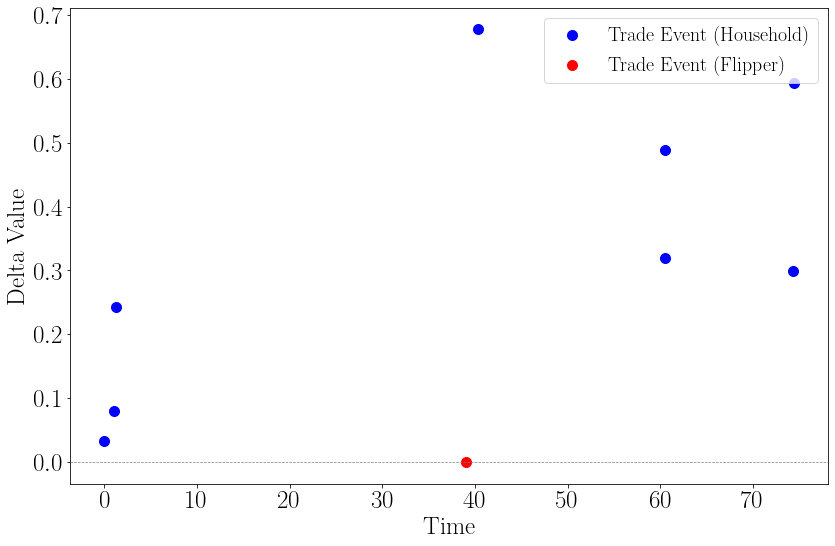

[(0, 'household', 0.03210958048205825),
 (10, 'household', 0.08003256976593665),
 (13, 'household', 0.24299759286082978),
 (390, 0.9358127584827265),
 (403, 'household', 0.6781253987792251),
 (605, 'household', 0.32002549570960714),
 (605, 'household', 0.4883117451756903),
 (743, 'household', 0.29996653395782813),
 (744, 'household', 0.5932191874223961)]

In [20]:
import matplotlib.pyplot as plt
import numpy as np

def plot_house_delta_and_trades(house_id, house_history, house_deltas, trade_history, ownership_indices, delta_history, T, dt):
    """Plot the delta of the owner of a specific house over time, marking trades with blue and red dots."""
    
    # Prepare data for the specific house
    total_steps = ownership_indices.shape[1]  # Total time steps
    time_points = np.arange(total_steps) * dt  # Create a time array

    # Extract the delta of the owner for the given house
    owner_deltas = []
    for step in range(total_steps):
        owner_index = ownership_indices[house_id, step]
        if owner_index >= 0 and owner_index < delta_history.shape[0]:  # Check bounds
            owner_deltas.append(delta_history[owner_index, step])
        else:
            owner_deltas.append(np.nan)  # No owner at this step or out of bounds

    # Create a plot
    plt.figure(figsize=(12, 8))

    # Plot the delta of the owner over time as a black line
    #plt.plot(time_points, owner_deltas, color='black', label='Delta of Owner', alpha=0.5)

    # Mark trades using house_history
    for entry in house_history[house_id]:
        step = entry[0]  # Time step
        if len(entry) == 3:  # Trade with household
            seller, delta_value = entry[1], entry[2]
            if step < total_steps:  # Ensure we do not go out of bounds
                plt.scatter(step * dt, delta_value, color='blue', s=100, label='Trade Event (Household)' if step == 0 else "")
        elif len(entry) == 2:  # Trade with flipper
            delta_value = entry[1]
            if step < total_steps:  # Ensure we do not go out of bounds
                plt.scatter(step * dt, 0, color='red', s=100, label='Trade Event (Flipper)' if step == 0 else "Trade Event (Flipper)")

    plt.axhline(0, color='gray', linestyle='--', linewidth=0.7)
    #plt.title(f"Delta History of House {house_id}")
    plt.xlabel('Time')
    plt.ylabel('Delta Value')
    plt.legend()
    plt.tight_layout()

    plt.show()

# Example usage
house_id_to_plot = 4  # Change this to the specific house ID you want to visualize
plot_house_delta_and_trades(house_id_to_plot, house_history, house_deltas, trade_history, ownership_indices, delta_history, T, dt)
house_history[4]

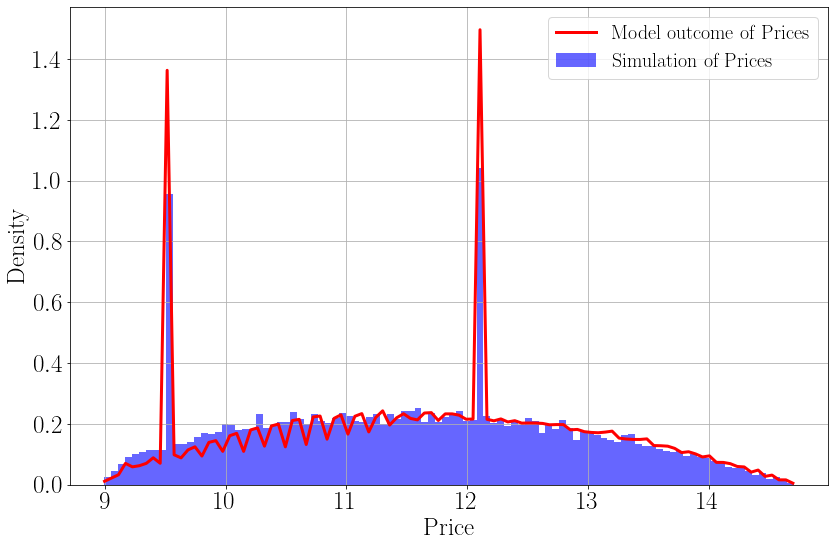

In [21]:
# Plot the histogram of prices and the PDF of prices on the same plot
prices_flat = np.ravel(price_history)
plt.figure(figsize=(12, 8))
plt.hist(prices_flat, bins=100, density=True, alpha=0.6, color='blue', label='Simulation of Prices')
plt.plot(p_values_mid, f_P, color='red', linewidth=3, label='Model outcome of Prices')
plt.xlabel('Price')
plt.ylabel('Density')
#plt.title('Histogram and PDF of Price Distribution')
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.show()


In [ ]:

fixed_params = {
    'f': f,
    's': s,
    'r': r,
    'gamma': gamma,
    'rho': rho,
    'lambda1': lambda1
}

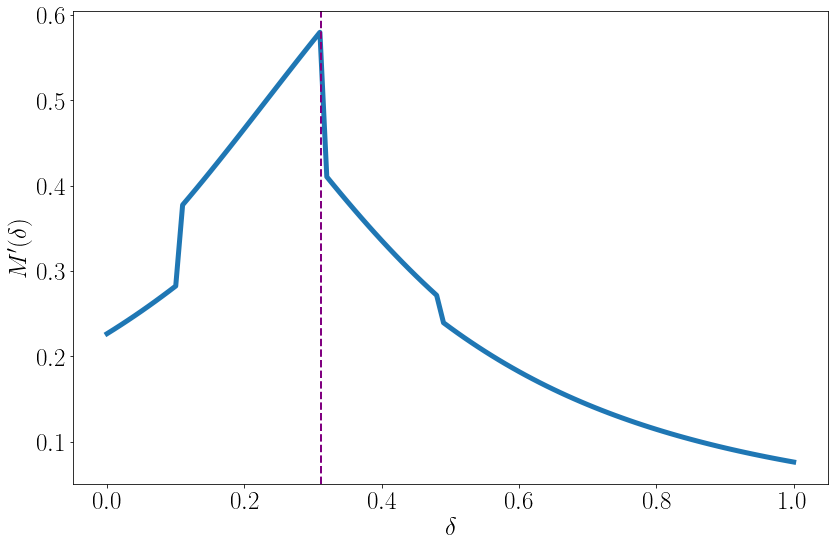

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Define the misallocation density function M'(delta)
def misallocation_density(delta_grid, delta_star, delta_0_star, delta_1_star, params):
    # Calculate dH0 and dH1 values across the delta_grid
    dH0_vals = np.array([dH0(delta, delta_0_star, delta_1_star, **params) for delta in delta_grid])
    dH1_vals = np.array([dH1(delta, delta_0_star, delta_1_star, **params) for delta in delta_grid])
    
    # Compute the misallocation density based on delta_star
    M_prime_vals = np.where(delta_grid <= delta_star, dH1_vals, dH0_vals)
    return M_prime_vals

# Unified plotting function for misallocation density
def plot_misallocation_density(param_name, param_values, fixed_params, delta_grid):
    plt.figure(figsize=(12, 8))
    delta_star = 1 - fixed_params['s']
    
    for param_value in param_values:
        params = fixed_params.copy()
        params[param_name] = param_value
        
        # Calculate optimal delta_0_star and delta_1_star for each parameter value
        delta_0_star, delta_1_star = find_optimal_deltas_iterative(
            params['r'], params['gamma'], params['s'], params['f'], params['lambda1'], params['rho'], 
            delta_grid, delta_0_star_initial, delta_1_star_initial
        )
        
        # Calculate misallocation density values
        M_prime_vals = misallocation_density(delta_grid, delta_star, delta_0_star, delta_1_star, params)
        
        # Plot the results
        plt.plot(delta_grid, M_prime_vals,linewidth=5, label=f'{param_name}={param_value}')

    # Mark the delta_star line
    plt.axvline(x=delta_star, color='purple',linewidth=2, linestyle='--', label='$\delta^*$')
    
    #plt.legend()
    plt.xlabel('$\delta$')
    plt.ylabel("$M'(\delta)$")
    
    #plt.title(f'Misallocation Density for varying {param_name}')
    #plt.grid(True)
    plt.tight_layout()

    plt.show()

# Example usage: Plot misallocation density for different values of f
f_values =[f]#[0.04, 0.08, 0.12, 0.24]
plot_misallocation_density('f', f_values, fixed_params, delta_grid)

# Example usage: Plot misallocation density for different values of gamma
# gamma_values = [0.1, 0.25, 0.5, 1.0]
# plot_misallocation_density('gamma', gamma_values, fixed_params, delta_grid)


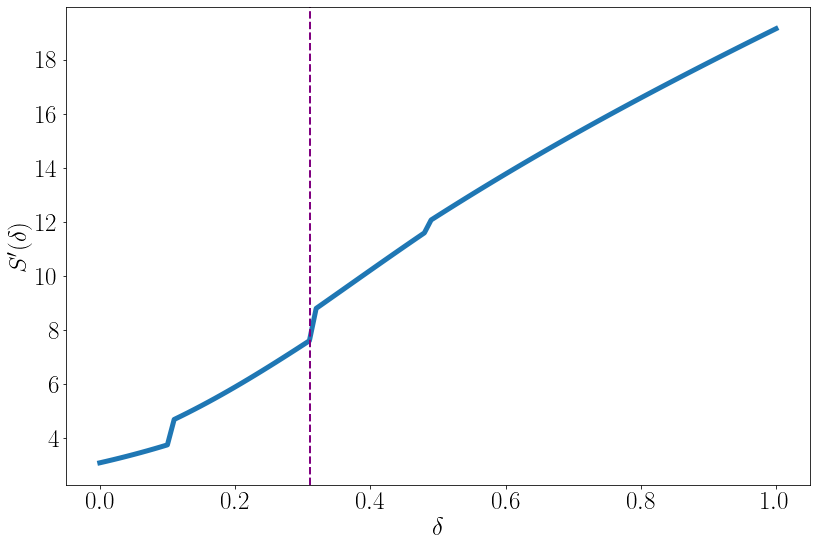

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Function to compute V^F(1, delta) and V^F(0, delta)
def V_F_1(delta, r, gamma, s, delta_star):
    return ( (1 - s) * (r - 1) / r * (delta < delta_star) 
            + delta * (delta >= delta_star) 
            + gamma * (1 - s)**2 / r 
            + gamma / (r - 1) * (0.5 - (1 - s)**2 / 2) ) / (r + gamma - 1)

def V_F_0(delta, r, gamma, s, delta_star):
    return ( (delta - (1 - s) * (r - 1) / r) * (delta >= delta_star) 
            - gamma * s * (1 - s) / r 
            + gamma / (r - 1) * (0.5 - (1 - s)**2 / 2) ) / (r + gamma - 1)

# Function to compute S'(delta)
def welfare_cost_density(delta_grid, V1_values, V0_values, dH1_values, dH0_values, params):
    delta_star = 1 - params['s']
    r = params['r']
    gamma = params['gamma']
    s = params['s']
    
    V_F1_values = np.array([V_F_1(delta, r, gamma, s, delta_star) for delta in delta_grid])
    V_F0_values = np.array([V_F_0(delta, r, gamma, s, delta_star) for delta in delta_grid])
    
    # Compute S'(delta)
    S_prime_vals = V0_values * dH0_values + V1_values * dH1_values - V_F0_values * (delta_grid < delta_star) - V_F1_values * (delta_grid >= delta_star)
    return S_prime_vals

# Unified plotting function for welfare cost density
def plot_welfare_cost_density(param_name, param_values, fixed_params, delta_grid):
    plt.figure(figsize=(12, 8))
    delta_star = 1 - fixed_params['s']
    
    for param_value in param_values:
        params = fixed_params.copy()
        params[param_name] = param_value
        
        # Calculate optimal delta_0_star and delta_1_star for each parameter value
        delta_0_star, delta_1_star = find_optimal_deltas_iterative(
            params['r'], params['gamma'], params['s'], params['f'], params['lambda1'], params['rho'], 
            delta_grid, delta_0_star_initial, delta_1_star_initial
        )
        params['optimal_delta_0_local'], params['optimal_delta_1_local'] = delta_0_star, delta_1_star
        Delta_V, matrix_to_invert = value_iteration(delta_grid, params['optimal_delta_0_local'], params['optimal_delta_1_local'],
                                                     r, gamma, s, f, lambda1, rho)

        Delta_V_interp = interp1d(delta_grid, Delta_V, kind='linear', fill_value="extrapolate")

        # Calculate V1, V0, and dH values
        V1_values, V0_values = calculate_V1_V0(delta_grid, Delta_V_interp, params)
        dH1_values = np.array([dH1(delta, params['optimal_delta_0_local'], params['optimal_delta_1_local'], params['r'], params['gamma'], params['s'], params['f'], params['lambda1'], params['rho']) for delta in delta_grid])
        dH0_values = np.array([dH0(delta, params['optimal_delta_0_local'], params['optimal_delta_1_local'], params['r'], params['gamma'], params['s'], params['f'], params['lambda1'], params['rho']) for delta in delta_grid])
        
        # Calculate welfare cost density values
        S_prime_vals = welfare_cost_density(delta_grid, V1_values, V0_values, dH1_values, dH0_values, params)

        # Plot the results
        plt.plot(delta_grid, S_prime_vals, linewidth=5, label=f'{param_name}={param_value}')

    # Mark the delta_star line
    plt.axvline(x=delta_star, color='purple', linewidth=2, linestyle='--', label='$\delta^*$')
    
    plt.xlabel('$\delta$')
    plt.ylabel("$S'(\delta)$")
    plt.tight_layout()

    plt.show()

# Example usage: Plot welfare cost density for different values of f
f_values = [f]  # Replace with actual values
plot_welfare_cost_density('f', f_values, fixed_params, delta_grid)

# Comparative statics

In [165]:
# Updated function to calculate all required variables
def calculate_variables(param_value, param_name, fixed_params, delta_grid):
    params = fixed_params.copy()
    params[param_name] = param_value
    
    # Calculate the optimal deltas based on the new parameter value
    optimal_deltas = find_optimal_deltas_iterative(
        params['r'], params['gamma'], params['s'], params['f'], params['lambda1'], params['rho'], 
        delta_grid, delta_0_star_initial,delta_1_star_initial
    )
    params['optimal_delta_0_local'], params['optimal_delta_1_local'] = optimal_deltas
    F1_value = F1(params['optimal_delta_0_local'], params['optimal_delta_1_local'], params['r'], 
                  params['gamma'], params['s'], params['f'], params['lambda1'], params['rho'])
    F0_value = params['f'] - F1_value
    
    # Compute H1_values and H0_values as arrays
    H1_values, H0_values = compute_H_values(
        delta_grid, params['optimal_delta_0_local'], params['optimal_delta_1_local'], 
        params['r'], params['gamma'], params['s'], params['f'], params['lambda1'], params['rho']    )

    # Initialize dH0_values and dH1_values as arrays by using the _gen functions
    dH0_values = dH0_gen(params['optimal_delta_0_local'], params['optimal_delta_1_local'], 
                         params['r'], params['gamma'], params['s'], params['f'], params['lambda1'], 
                         params['rho']    )
    dH1_values = dH1_gen(params['optimal_delta_0_local'], params['optimal_delta_1_local'], 
                         params['r'], params['gamma'], params['s'], params['f'], params['lambda1'], 
                         params['rho']    )

    # Perform value iteration
    Delta_V, _ = value_iteration(
        delta_grid, params['optimal_delta_0_local'], params['optimal_delta_1_local'], params['r'], 
        params['gamma'], params['s'], params['f'], params['lambda1'], params['rho']    )

    Delta_V_interp = interp1d(delta_grid, Delta_V, kind='linear', fill_value="extrapolate")
    
    P0_value = P0(Delta_V_interp, params['optimal_delta_1_local'])
    P1_value = P1(Delta_V_interp, params['optimal_delta_0_local'])
    P_star_value = (1 - params['s']) / params['r']

    # Compute V1 and V0
    V1_values, V0_values = calculate_V1_V0(
        delta_grid, Delta_V_interp, params    )

    # Calculate trade volumes and mean price/variance
    kappa, kappa1, kappa2 = trade_volume(
        params['r'], params['gamma'], params['s'], params['f'], params['lambda1'], params['rho'], 
        dH0_values, dH1_values, params['optimal_delta_0_local'], params['optimal_delta_1_local']    )
    
    p_values, F_P = price_distribution(
        params['r'], params['gamma'], params['s'], params['f'], params['lambda1'], params['rho'],
        Delta_V_interp, dH0_values, dH1_values, kappa1, kappa2,
        params['optimal_delta_0_local'], params['optimal_delta_1_local']    )
    
    P_mean, P_variance = compute_P_mean_variance(
        p_values, F_P    )
    
    # Calculate welfare and integrals
    W0_val = W0(params['optimal_delta_0_local'], params['optimal_delta_1_local'], params['r'], 
                params['gamma'], params['s'], params['f'], params['lambda1'], params['rho'])
    W1_val = W1(params['optimal_delta_0_local'], params['optimal_delta_1_local'], params['r'], 
                params['gamma'], params['s'], params['f'], params['lambda1'], params['rho'])
    
    intV1, intV0, welfare_agent, intW0, intW1, welfare_flipper = calculate_welfare(
        V1_values, V0_values, dH1_values, dH0_values, delta_grid, F0_value, F1_value, W0_val, 
        W1_val, params    )

    results = {
        'delta_0_star': params['optimal_delta_0_local'],
        'delta_1_star': params['optimal_delta_1_local'],
        'F1_value': F1_value,
        'F0_value': F0_value,
        'P0_value': P0_value,
        'P1_value': P1_value,
        'P_star_value': P_star_value,
        'P_mean': P_mean,
        'P_variance': P_variance,
        'intV0': intV0,
        'intV1': intV1,
        'welfare_agent': welfare_agent,
        'intW0': intW0,
        'intW1': intW1,
        'welfare_flipper': welfare_flipper,
        'trade_hh': kappa1,
        'trade_flipper': kappa2,
        'trade_volume': kappa,
        'shared_flippped': kappa2/kappa,
        'avg_time_lived': kappa/params['s'],
        'return_flipping': P1_value-P0_value,
    }
    
    return results

# Function to plot the variables
def plot_variables(param_draws, results_list, param_name):
    grouped_variables = [
        {'delta_0_star', 'delta_1_star'},
        {'F1_value', 'F0_value'},
        {'P0_value', 'P1_value', 'P_mean', 'P_variance', 'P_star_value'},
        {'intV0', 'intV1'},
        {'welfare_agent', 'welfare_flipper'},
        {'trade_hh', 'trade_flipper', 'trade_volume'},
        {'shared_flippped','avg_time_lived','return_flipping'}
    ]
    
    plt.rcParams['text.usetex'] = False
    
    for group in grouped_variables:
        plt.figure(figsize=(12, 8))
        for var in group:
            values = [result[var] for result in results_list]
            plt.plot(param_draws, values, marker='o', linestyle='-', linewidth=3, label=var)
        plt.title(f'{", ".join(group)} as Function of {param_name}')
        plt.xlabel(param_name.capitalize())
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True)
        plt.show()

# Comparative statics exercise function
def comparative_statics_exercise(param_name, param_min, param_max, fixed_params, delta_grid, N_draws):
    param_draws = np.linspace(param_min, param_max, N_draws)
    
    results_list = []
    for param_value in param_draws:
        results = calculate_variables(param_value, param_name, fixed_params, delta_grid)
        results_list.append(results)
        
    return param_draws, results_list



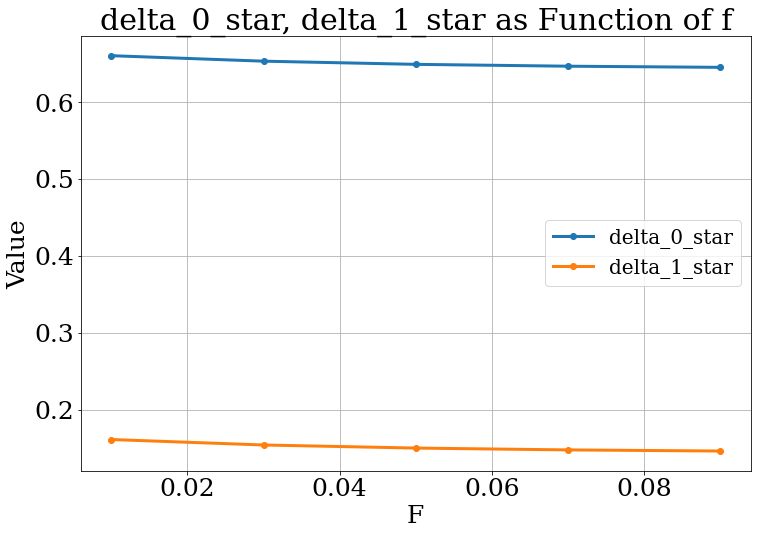

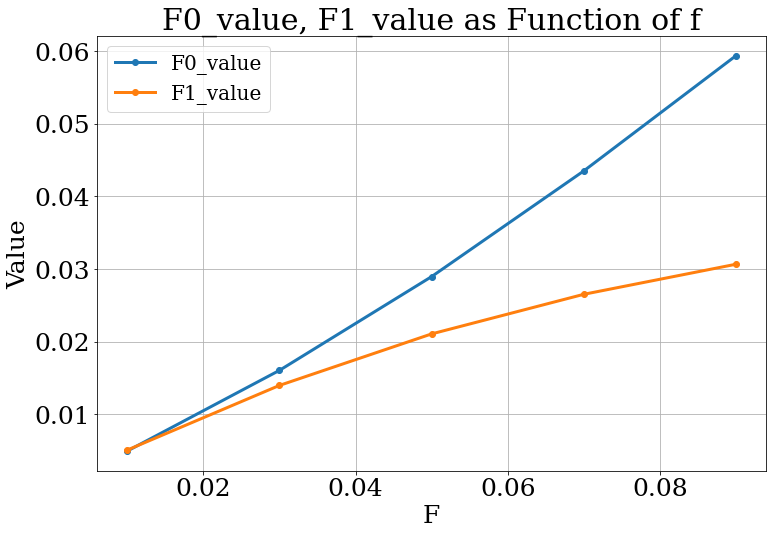

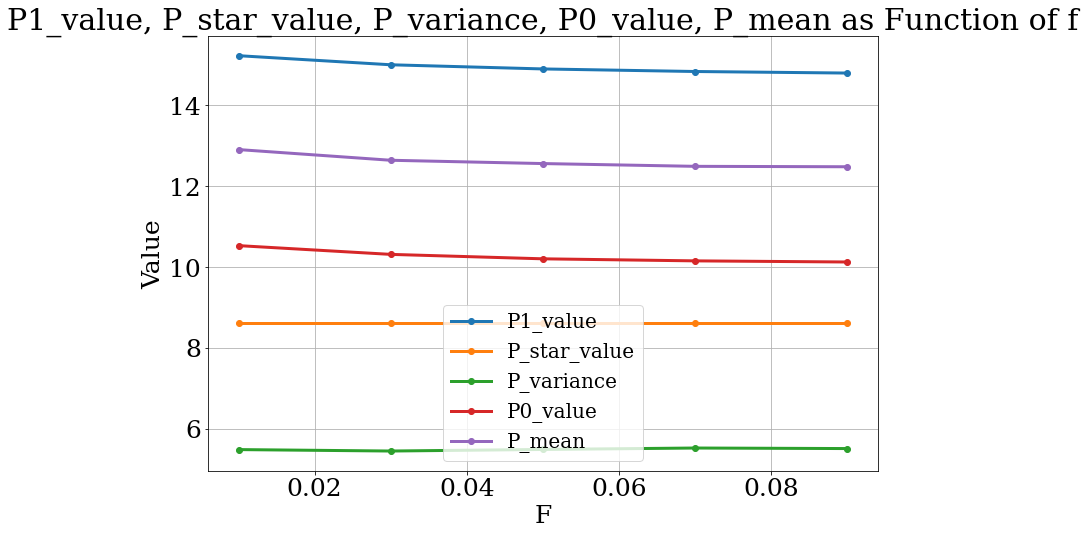

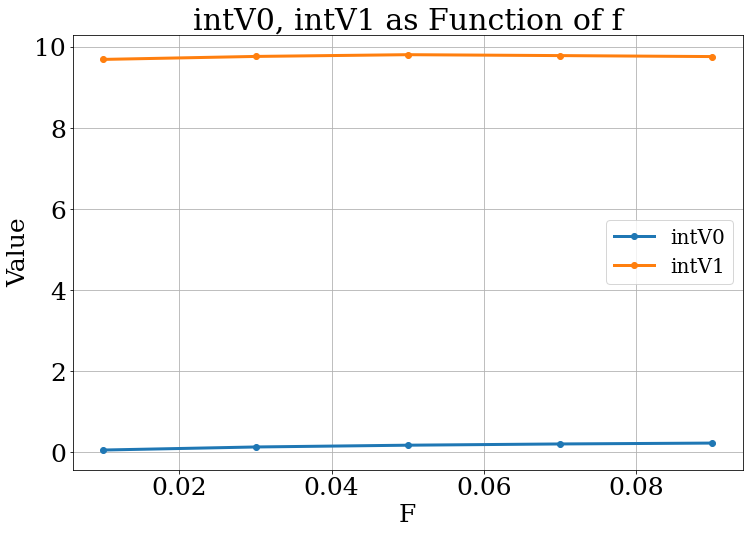

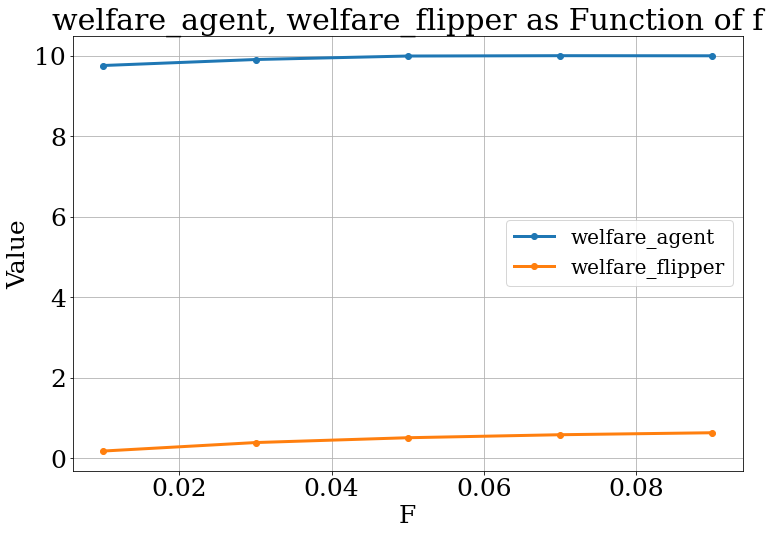

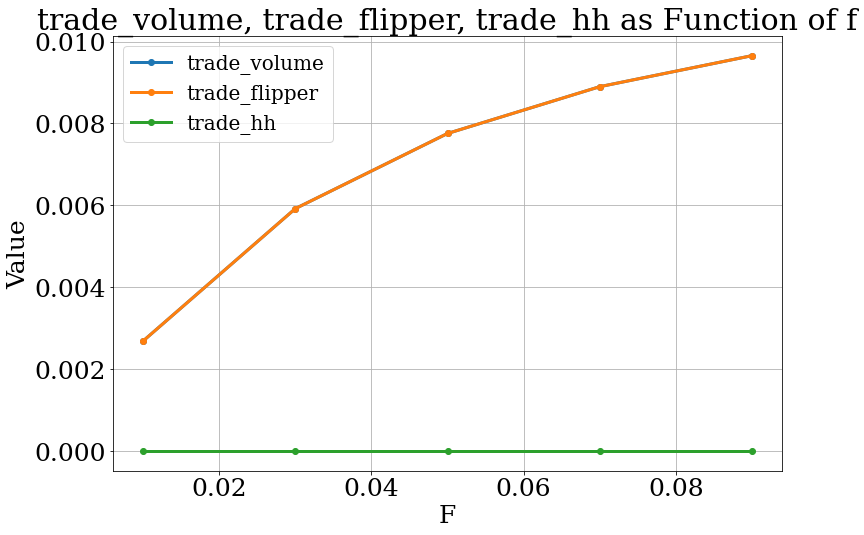

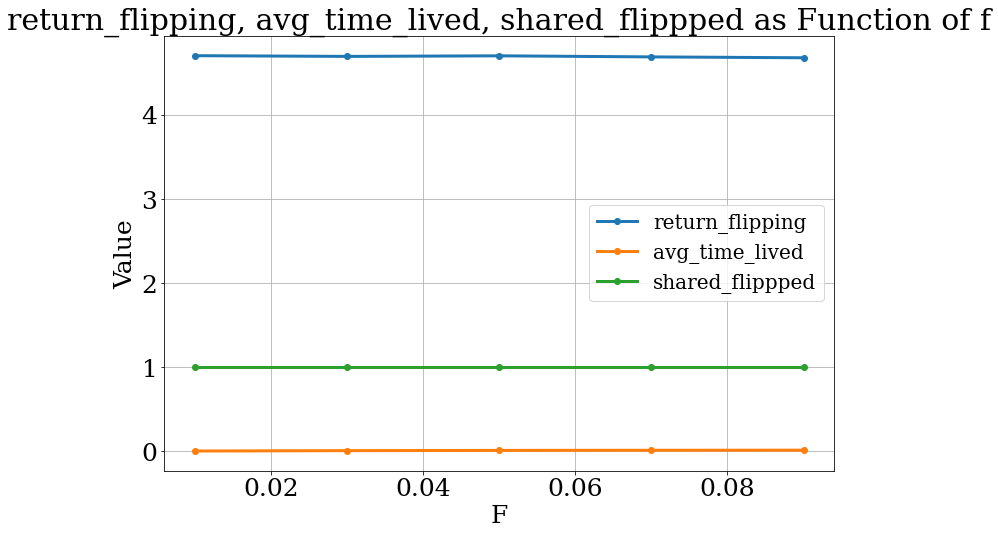

In [166]:
# Generate delta_grid

N_draws = 5
delta_grid = np.linspace(0, 1, 101)

# Example usage: Plot variables for different values of f
param_draws, results_list = comparative_statics_exercise('f', 0.01, 0.09, fixed_params, delta_grid, N_draws)
plot_variables(param_draws, results_list, 'f')

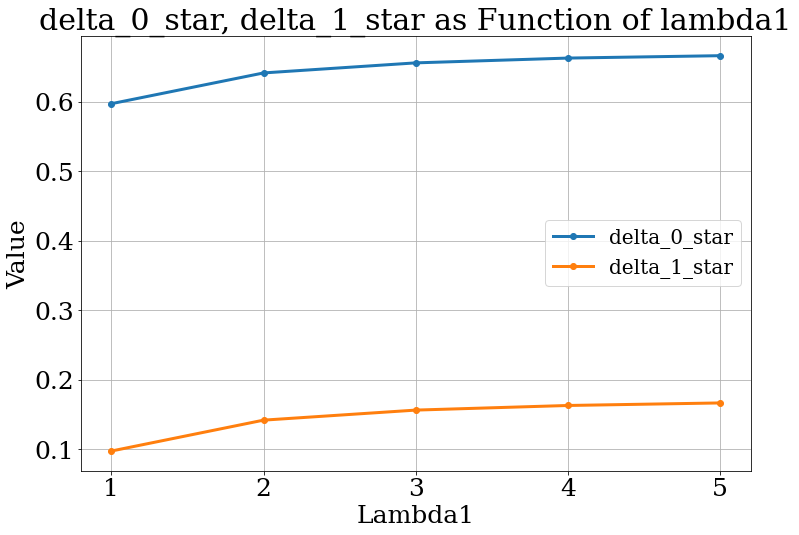

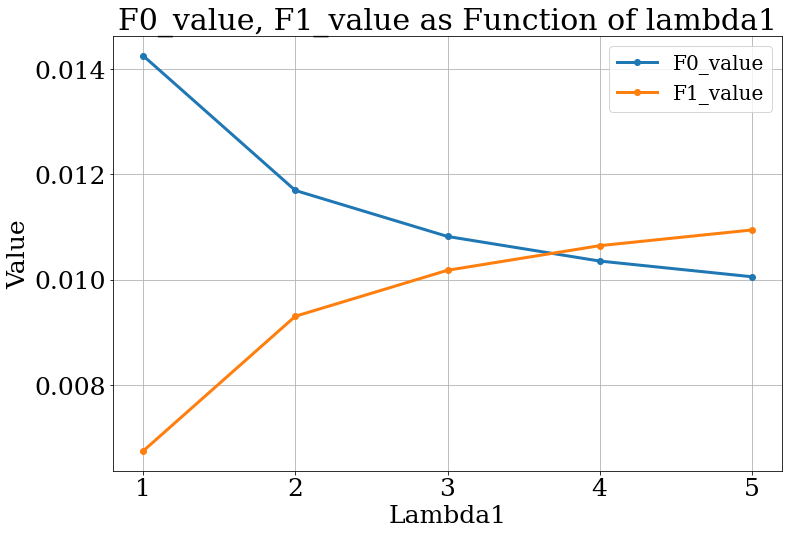

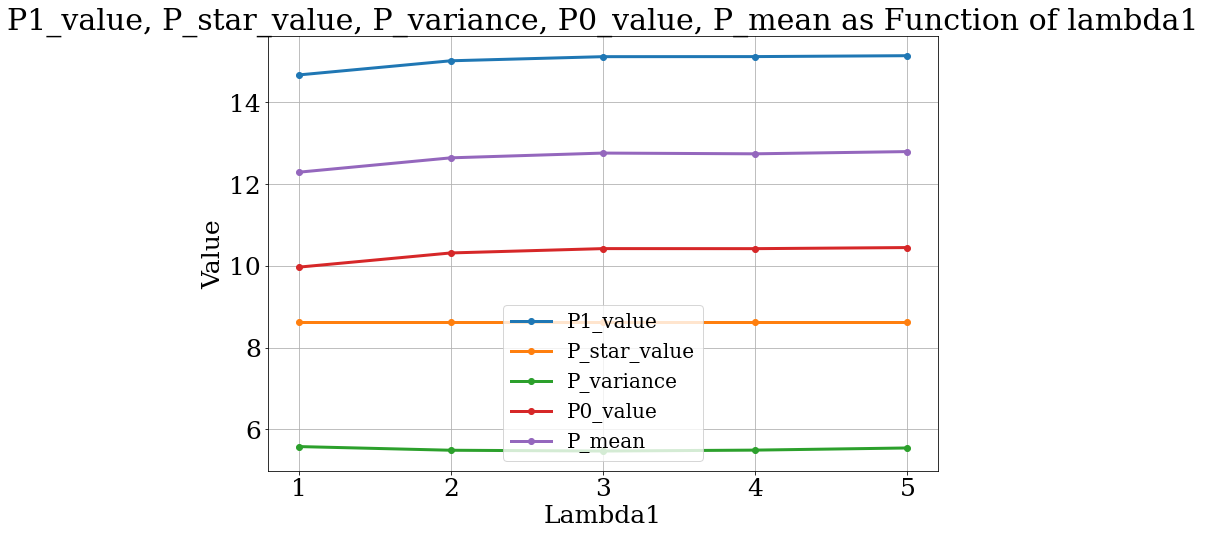

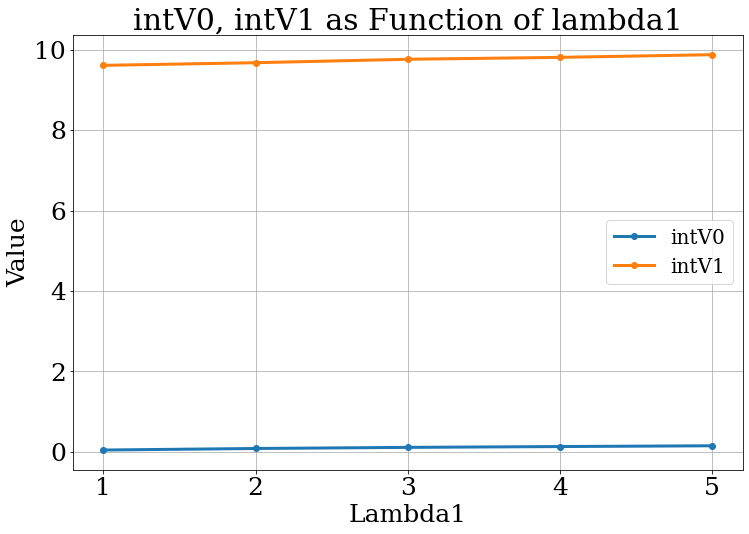

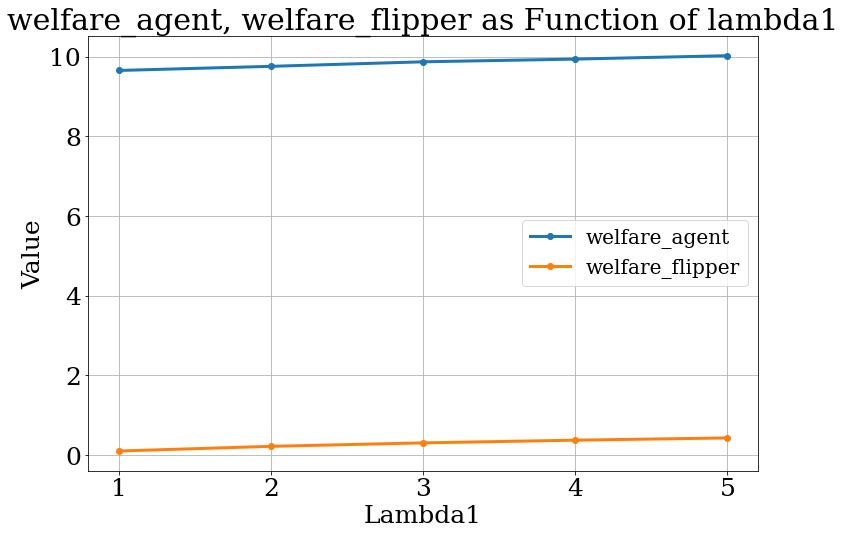

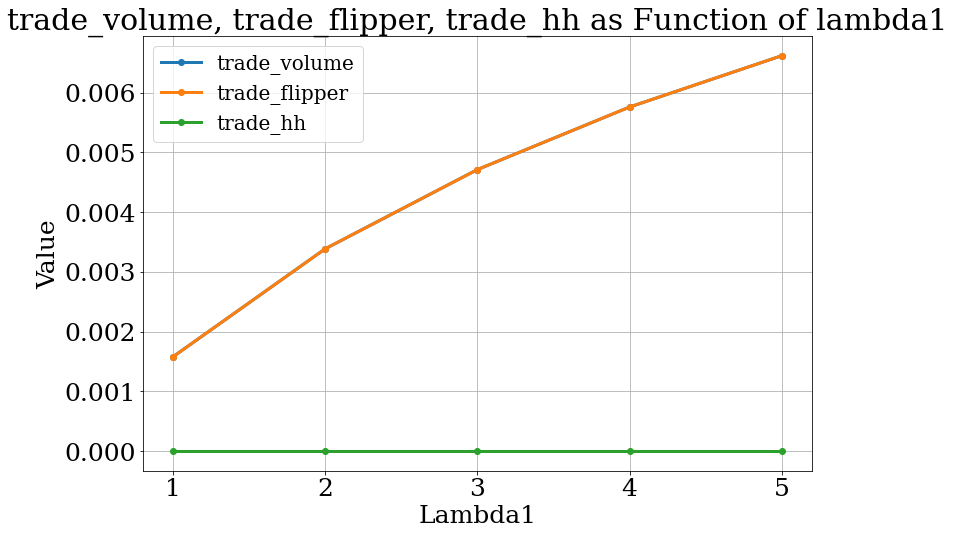

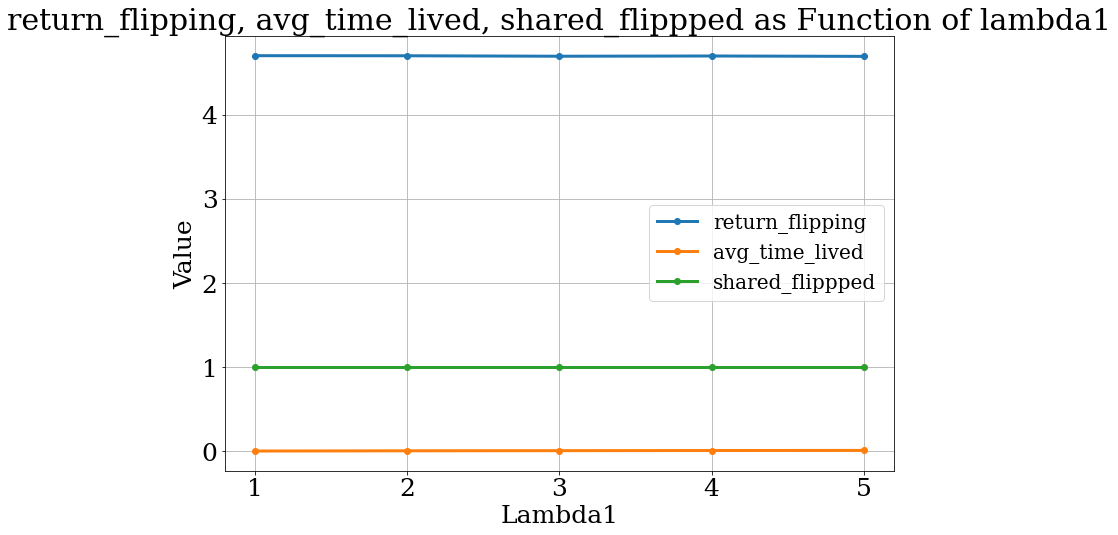

In [167]:
N_draws = 5

# Perform comparative statics
param_draws3, results_list3 = comparative_statics_exercise('lambda1', 1.0, 5.0, fixed_params, delta_grid, N_draws)

# Plot variables
plot_variables(param_draws3, results_list3, 'lambda1')


# Calibration, Estimation

In [24]:
def steady_state(r, gamma, s, f, lambda1, rho, delta_grid,delta_0_star_initial, delta_1_star_initial, 
                 tolerance=1e-2):
    # Define the parameters dictionary
    params = {
        'r': r,
        'gamma': gamma,
        's': s,
        'f': f,
        'lambda1': lambda1,
        'rho': rho
    }

    # Calculate the optimal deltas based on the parameters
    optimal_deltas = find_optimal_deltas_iterative(
        r, gamma, s, f, lambda1, rho, delta_grid, delta_0_star_initial, delta_1_star_initial,tolerance#0.0800678823874261,0.000341049631986165,
    )
    params['optimal_delta_0_local'], params['optimal_delta_1_local'] = optimal_deltas

    # Calculate F1 and F0 values
    F1_value = F1(params['optimal_delta_0_local'], params['optimal_delta_1_local'], r, gamma, s, f, lambda1, rho)
    F0_value = f - F1_value
    
    # Compute H1 and H0 values as arrays
    H1_values, H0_values = compute_H_values(
        delta_grid, params['optimal_delta_0_local'], params['optimal_delta_1_local'], r, gamma, s, f, lambda1, rho
    )

    # Initialize dH0 and dH1 values as arrays using the generated functions
    dH0_values = dH0_gen(
         params['optimal_delta_0_local'], params['optimal_delta_1_local'], r, gamma, s, f, lambda1, rho
    )
    dH1_values = dH1_gen(
        params['optimal_delta_0_local'], params['optimal_delta_1_local'], r, gamma, s, f, lambda1, rho
    )

    # Perform value iteration to get Delta_V
    Delta_V, _ = value_iteration(
        delta_grid, params['optimal_delta_0_local'], params['optimal_delta_1_local'], r, gamma, s, f, lambda1, rho
    )

    # Interpolate Delta_V
    Delta_V_interp = interp1d(delta_grid, Delta_V, kind='linear', fill_value="extrapolate")
    
    # Calculate price-related values
    P0_value = P0(Delta_V_interp, params['optimal_delta_1_local'])
    P1_value = P1(Delta_V_interp, params['optimal_delta_0_local'])
    P_star_value = (1 - s) / r

     # Compute V1 and V0
    V1_values, V0_values = calculate_V1_V0(
        delta_grid, Delta_V_interp, params
    )

    # Calculate trade volumes and mean price/variance
    kappa, kappa1, kappa2 = trade_volume(
        params['r'], params['gamma'], params['s'], params['f'], params['lambda1'], params['rho'], dH0_values, dH1_values, params['optimal_delta_0_local'], params['optimal_delta_1_local']
    )
    kappa_hh_over2, kappa_flipper_under2=trade_volume_2years(
        params['r'], params['gamma'], params['s'], params['f'], params['lambda1'], params['rho'], dH0_values, dH1_values, params['optimal_delta_0_local'], params['optimal_delta_1_local']
    )
    #kappa_flipper_under2=kappa2/2*(2-np.exp(-kappa2/F0_value)-np.exp(-kappa2/F1_value))
    p_values, F_P = price_distribution(
        params['r'], params['gamma'], params['s'], params['f'], params['lambda1'], params['rho'],
        Delta_V_interp, dH0_values, dH1_values, kappa1, kappa2,
        params['optimal_delta_0_local'], params['optimal_delta_1_local']
    )
    
    P_mean, P_variance = compute_P_mean_variance(
        p_values, F_P
    )
    
    # Calculate welfare and integrals
    W0_val = W0(params['optimal_delta_0_local'], params['optimal_delta_1_local'], params['r'], params['gamma'], params['s'], params['f'], params['lambda1'], params['rho'])
    W1_val = W1(params['optimal_delta_0_local'], params['optimal_delta_1_local'], params['r'], params['gamma'], params['s'], params['f'], params['lambda1'], params['rho'])
    
    intV1, intV0, welfare_agent, intW0, intW1, welfare_flipper = calculate_welfare(
        V1_values, V0_values, dH1_values, dH0_values, delta_grid, F0_value, F1_value, W0_val, W1_val, params
    )

    # Store and return the results
    results = {
        'delta_0_star': params['optimal_delta_0_local'],
        'delta_1_star': params['optimal_delta_1_local'],
        'F1_value': F1_value,
        'F0_value': F0_value,
        'P0_value': P0_value,
        'P1_value': P1_value,
        'P_star_value': P_star_value,
        'P_mean': P_mean,
        'P_variance': P_variance,
        'intV0': intV0,
        'intV1': intV1,
        'welfare_agent': welfare_agent,
        'intW0': intW0,
        'intW1': intW1,
        'welfare_flipper': welfare_flipper,
        'trade_hh': kappa1,
        'trade_flipper': kappa2,
        'trade_volume': kappa,
        'shared_flipped2': kappa2/kappa,
        'avg_time_lived': kappa/params['s'],
        'return_flipping': P1_value - P0_value,
        'return_flipping2': P1_value/P0_value,
        'homeownership':s-F1_value,
        'shared_flipped': kappa_flipper_under2/(kappa_hh_over2+ kappa_flipper_under2),
        'kappa2':kappa2,
        'kappa1':kappa1,
        'kappa_flipper_under2':kappa_flipper_under2,
        'kappa_hh_over2':kappa_hh_over2,
    }
    
    return results


In [25]:
import gc

# Force garbage collection before each run
gc.collect()


6362

## Results of Baseline estimation

In [37]:
# FINAL CALIBRATION
# Global variables for targets, parameters, and grid
target_shared_flipped = 0.04556621
target_avg_time_lived = 1 / 17.88092422
target_return_flipping = 1.29333568
target_P_mean = 11.42398907
target_homeownership = 0.6884162140  # New target for homeownership


s = 0.6884162140  # Starting value for s, this will be estimated in new calibration
r = 0.0361577940

f,gamma,rho,lambda1,delta_0_star_initial, delta_1_star_initial=0.021,0.07,0.3,3,0.483672706,0.106481650304695

delta_bar = 1
delta_grid = np.linspace(0, delta_bar, 101)

# Weighting matrix
W = np.eye(5)  # Identity matrix for weighting (includes homeownership as the fifth variable)

# Start timing the computation of the objective function
start_time = time.time()

# Compute the steady state with the initial parameter values
steady_state_result = steady_state(r, gamma, s, f, lambda1, rho, delta_grid, delta_0_star_initial, delta_1_star_initial)

# Extract the moments of interest from the steady state results
shared_flipped = steady_state_result['shared_flipped']
avg_time_lived = steady_state_result['avg_time_lived']
return_flipping = steady_state_result['return_flipping2']
P_mean = steady_state_result['P_mean']
homeownership = steady_state_result['homeownership']  # Extracting homeownership from the model

# Calculate the differences from the target moments
diff_shared_flipped = (shared_flipped - target_shared_flipped) / target_shared_flipped
diff_avg_time_lived = (avg_time_lived - target_avg_time_lived) / target_avg_time_lived
diff_return_flipping = (return_flipping - target_return_flipping) / target_return_flipping
diff_P_mean = (P_mean - target_P_mean) / target_P_mean
diff_homeownership = (homeownership - target_homeownership) / target_homeownership

# Compute the objective function value using the updated weighting matrix
moments = np.array([diff_shared_flipped, diff_avg_time_lived, diff_return_flipping, diff_P_mean, diff_homeownership])
objective_value = moments @ W @ moments.T

end_time = time.time()  # End timing
elapsed_time = end_time - start_time  # Calculate elapsed time

# Print the results
print(f"Objective function value: {objective_value:.6f}")
print(f"Time taken for one iteration: {elapsed_time:.4f} seconds")
print(f"Shared Flipped: {shared_flipped * 100:.2f}% (Target: {target_shared_flipped * 100:.2f}%)")
print(f"Avg Time Lived: {avg_time_lived * 100:.2f}% (Target: {target_avg_time_lived * 100:.2f}%)")
print(f"Return Flipping: {return_flipping * 100:.2f}% (Target: {target_return_flipping * 100:.2f}%)")
print(f"P Mean: {P_mean:.6f} (Target: {target_P_mean})")
print(f"Homeownership: {homeownership:.6f} (Target: {target_homeownership})")
print(f"Results: {steady_state_result}")


Objective function value: 0.302473
Time taken for one iteration: 17.1761 seconds
Shared Flipped: 4.81% (Target: 4.56%)
Avg Time Lived: 2.54% (Target: 5.59%)
Return Flipping: 126.96% (Target: 129.33%)
P Mean: 11.621838 (Target: 11.42398907)
Homeownership: 0.682673 (Target: 0.688416214)
Results: {'delta_0_star': 0.483672706, 'delta_1_star': 0.106481650304695, 'F1_value': 0.005742752945465381, 'F0_value': 0.015257247054534621, 'P0_value': array(9.51416121), 'P1_value': array(12.07920443), 'P_star_value': 8.617333955716436, 'P_mean': 11.621838042455643, 'P_variance': 1.7963533474771665, 'intV0': 0.6012317755429158, 'intV1': 10.51049154171801, 'welfare_agent': 11.111723317260925, 'intW0': 0.02238263747426971, 'intW1': 0.06690727312030689, 'welfare_flipper': 0.08928991059457661, 'trade_hh': 0.014971568431986677, 'trade_flipper': 0.00248858436905963, 'trade_volume': 0.017460152801046305, 'shared_flipped2': 0.1425293579853723, 'avg_time_lived': 0.025362785544511168, 'return_flipping': 2.565043

<h1>Counterfactual increase f</h1>


In [27]:
f_counterfactual=0.05191190679787796
f_shared_flipped=f_counterfactual

In [28]:
def important_variables(param_value, param_name, fixed_params, delta_grid):
    params = fixed_params.copy()
    params[param_name] = param_value
    
    # Calculate the optimal deltas based on the new parameter value
    optimal_deltas = find_optimal_deltas_iterative(
        params['r'], params['gamma'], params['s'], params['f'], params['lambda1'], params['rho'], delta_grid,
         delta_0_star_initial, delta_1_star_initial
    )
    params['optimal_delta_0_local'], params['optimal_delta_1_local'] = optimal_deltas
    
    # Compute F1 and F0 values
    F1_value = F1(params['optimal_delta_0_local'], params['optimal_delta_1_local'], 
                  params['r'], params['gamma'], params['s'], params['f'], params['lambda1'], params['rho'])
    F0_value = params['f'] - F1_value
    
    # Compute H1_values and H0_values as arrays
    H1_values, H0_values = compute_H_values(
        delta_grid, params['optimal_delta_0_local'], params['optimal_delta_1_local'], 
        params['r'], params['gamma'], params['s'], params['f'], params['lambda1'], params['rho']
    )

    # Initialize dH0_values and dH1_values as arrays by using the _gen functions
    dH0_values = dH0_gen(params['optimal_delta_0_local'], params['optimal_delta_1_local'], 
                         params['r'], params['gamma'], params['s'], params['f'], params['lambda1'], params['rho'])
    dH1_values = dH1_gen(params['optimal_delta_0_local'], params['optimal_delta_1_local'], 
                         params['r'], params['gamma'], params['s'], params['f'], params['lambda1'], params['rho'])

    # Perform value iteration
    Delta_V, _ = value_iteration(
        delta_grid, params['optimal_delta_0_local'], params['optimal_delta_1_local'], 
        params['r'], params['gamma'], params['s'], params['f'], params['lambda1'], params['rho']
    )

    # Interpolate Delta_V
    Delta_V_interp = interp1d(delta_grid, Delta_V, kind='linear', fill_value="extrapolate")
    
    # Calculate P0, P1, and P_star values
    P0_value = P0(Delta_V_interp, params['optimal_delta_1_local'])
    P1_value = P1(Delta_V_interp, params['optimal_delta_0_local'])
    P_star_value = (1 - params['s']) / params['r']

    # Compute V1 and V0 values
    V1_values, V0_values = calculate_V1_V0(
        delta_grid, Delta_V_interp, params
    )
    V1_interp = interp1d(delta_grid, V1_values, kind='linear', fill_value="extrapolate")
    V0_interp = interp1d(delta_grid, V0_values, kind='linear', fill_value="extrapolate")

    # Calculate trade volumes and mean price/variance
    kappa, kappa1, kappa2 = trade_volume(
        params['r'], params['gamma'], params['s'], params['f'], params['lambda1'], params['rho'], 
        dH0_values, dH1_values, params['optimal_delta_0_local'], params['optimal_delta_1_local']
    )
    kappa_hh_over2, kappa_flipper_under2=trade_volume_2years(
        params['r'], params['gamma'], params['s'], params['f'], params['lambda1'], params['rho'], dH0_values, dH1_values, params['optimal_delta_0_local'], params['optimal_delta_1_local']
    )
    
    p_values, F_P = price_distribution(
        params['r'], params['gamma'], params['s'], params['f'], params['lambda1'], params['rho'],
        Delta_V_interp, dH0_values, dH1_values, kappa1, kappa2,
        params['optimal_delta_0_local'], params['optimal_delta_1_local']
    )
    
    P_mean, P_variance = compute_P_mean_variance(
        p_values, F_P
    )
    
    # Calculate welfare and integrals
    W0_val = W0(params['optimal_delta_0_local'], params['optimal_delta_1_local'], 
                params['r'], params['gamma'], params['s'], params['f'], params['lambda1'], params['rho'])
    W1_val = W1(params['optimal_delta_0_local'], params['optimal_delta_1_local'], 
                params['r'], params['gamma'], params['s'], params['f'], params['lambda1'], params['rho'])
    
    intV1, intV0, welfare_agent, intW0, intW1, welfare_flipper = calculate_welfare(
        V1_values, V0_values, dH1_values, dH0_values, delta_grid, F0_value, F1_value, W0_val, W1_val, params
    )

    # Additional calculations for misallocations
    delta_star = (1 - params['s']) 
    delta_star_idx = np.searchsorted(delta_grid, delta_star)
    if delta_star_idx >= len(delta_grid):
        delta_star_idx = len(delta_grid) - 1
    non_owners_misallocation = H1_values[delta_star_idx]
    owners_misallocation = H0_values[-1]-H0_values[delta_star_idx]
    total_misallocation = non_owners_misallocation + owners_misallocation

    # Calculate shared_flipped, avg_time_lived, and turnover
    shared_flipped2 = kappa2 / kappa
    avg_time_lived = kappa / params['s']
    turnover = kappa / params['s']
    
    # Adjust welfare per capita calculations using H1 and H0 values at delta_grid[-1]
    welfare_flipper_per_capita = params['r']*welfare_flipper / params['f']
    welfare_homeowners_per_capita = params['r']*intV1 / H1_values[-1]
    welfare_non_homeowners_per_capita = params['r']*intV0 / H0_values[-1]
    total_welfare_per_capita=params['r']*(welfare_agent + welfare_flipper) / (1 + params['f'])
    # Prepare results dictionary
    results = {
        'delta_0_star': params['optimal_delta_0_local'],
        'delta_1_star': params['optimal_delta_1_local'],
        'F1_value': F1_value,
        'F0_value': F0_value,
        'P0_value': P0_value,
        'P1_value': P1_value,
        'P_star_value': P_star_value,
        'P_mean': P_mean,
        'P_variance': P_variance,
        'intV0': intV0,
        'intV1': intV1,
        #'welfare_agent': welfare_agent,
        'intW0': intW0,
        'intW1': intW1,
        'welfare_flipper': welfare_flipper,
        'trade_hh': kappa1,
        'trade_flipper': kappa2,
        'trade_volume': kappa,
        'shared_flipped2': shared_flipped2,
        'shared_flipped':kappa_flipper_under2/(kappa_hh_over2+kappa_flipper_under2),
        'avg_time_lived': avg_time_lived,
        'return_flipping': P1_value - P0_value,
        'return_flipping2': P1_value/P0_value,
        'turnover': turnover,
        'welfare_agent':params['r']*welfare_agent,#(intV1+intV0)/(H1_values[-1]+H0_values[-1]),
        'welfare_flipper_per_capita': welfare_flipper_per_capita,
        'welfare_homeowners_per_capita': welfare_homeowners_per_capita,
        'welfare_non_homeowners_per_capita': welfare_non_homeowners_per_capita,
        'total_welfare_per_capita': total_welfare_per_capita ,
        'non_owners_misallocation': non_owners_misallocation,
        'owners_misallocation': owners_misallocation,
        'total_misallocation': total_misallocation,
        'dH0_values': dH0_values,
        'dH1_values': dH1_values,
        'V0_values': V0_values,  # Ensure V0_values is added
        'V1_values': V1_values,  # Ensure V1_values is added
        'V0_interp': V0_interp,
        'V1_interp': V1_interp,
        'p_values': p_values,  # Add the price vector to the results dictionary
        'F_P': F_P, 
        'W0': W0_val,  # Ensure W0 is calculated and added
        'W1': W1_val,  # Ensure W1 is calculated and added
    }
    
    return results


In [29]:
import cProfile
import pstats
def counterfactual_exercise(param_name, param_min, param_max, fixed_params, delta_grid, N_draws):
    param_draws = np.linspace(param_min, param_max, N_draws)
    
    results_list = []
    for param_value in param_draws:
        results = important_variables(param_value, param_name, fixed_params, delta_grid)
        results_list.append(results)
        
    return param_draws, results_list


In [30]:
f_baseline = f
f_counterfactual = f_shared_flipped

# Run the model for both values of f
param_draws_baseline, results_list_baseline = counterfactual_exercise('f', f_baseline, f_baseline, fixed_params, delta_grid, 1)
param_draws_counterfactual, results_list_counterfactual = counterfactual_exercise('f', f_counterfactual, f_counterfactual, fixed_params, delta_grid, 1)

# Extract results
results_baseline = results_list_baseline[0]
results_counterfactual = results_list_counterfactual[0]


In [35]:
# Variables to save
variables_to_save = [
    'delta_0_star', 'delta_1_star', 'P0_value', 'P1_value','P_star_value', 'p_values','F_P' ,
    'W0', 'W1', 'V0_values', 'V1_values', 'dH0_values', 'dH1_values', 
    'F0_value', 'F1_value'
]

# Save necessary values for recreating interpolation functions
saved_results = {
    'baseline': {var: results_baseline[var] for var in variables_to_save},
    'counterfactual': {var: results_counterfactual[var] for var in variables_to_save},
}

# Convert the saved results to a DataFrame for easier viewing
saved_results_df = pd.DataFrame({key: pd.Series(value) for key, value in saved_results.items()})

# Optional: Display the DataFrame to check for any NaNs or inconsistencies
#print(saved_results_df)

In [36]:
import numpy as np
import pandas as pd

# Save scalar values into a dictionary
scalar_saved_results = {
    'baseline': {
        'delta_0_star': results_baseline['delta_0_star'],
        'delta_1_star': results_baseline['delta_1_star'],
        'F1_value': results_baseline['F1_value'],
        'F0_value': results_baseline['F0_value'],
        'P0_value': results_baseline['P0_value'],
        'P1_value': results_baseline['P1_value'],
        'P_star_value': results_baseline['P_star_value'],
        'trade_volume': results_baseline['trade_volume'],  # Add missing key
        'trade_hh': results_baseline['trade_hh'],  # Add missing key
        'trade_flipper': results_baseline['trade_flipper'],  # Add missing key
        'P_mean': results_baseline['P_mean'],
        'P_variance': results_baseline['P_variance'],
        'shared_flipped': results_baseline['shared_flipped'],
        'return_flipping2': results_baseline['return_flipping2'],
        'avg_time_lived': results_baseline['avg_time_lived'],
        'welfare_agent': results_baseline['welfare_agent'],
        # Add missing keys for welfare calculations
        'total_welfare_per_capita': results_baseline['total_welfare_per_capita'],
        'welfare_homeowners_per_capita': results_baseline['welfare_homeowners_per_capita'],
        'welfare_non_homeowners_per_capita': results_baseline['welfare_non_homeowners_per_capita'],
        'welfare_flipper_per_capita': results_baseline['welfare_flipper_per_capita'],
        'total_misallocation': results_baseline['total_misallocation'],
        'owners_misallocation': results_baseline['owners_misallocation'],
        'non_owners_misallocation': results_baseline['non_owners_misallocation'],
        'W0': results_baseline['W0'],  # Add W0
        'W1': results_baseline['W1'],  # Add W1
    },
    'counterfactual': {
        'delta_0_star': results_counterfactual['delta_0_star'],
        'delta_1_star': results_counterfactual['delta_1_star'],
        'F1_value': results_counterfactual['F1_value'],
        'F0_value': results_counterfactual['F0_value'],
        'P0_value': results_counterfactual['P0_value'],
        'P1_value': results_counterfactual['P1_value'],
        'P_star_value': results_counterfactual['P_star_value'],
        'trade_volume': results_counterfactual['trade_volume'],  # Add missing key
        'trade_hh': results_counterfactual['trade_hh'],  # Add missing key
        'trade_flipper': results_counterfactual['trade_flipper'],  # Add missing key
        'P_mean': results_counterfactual['P_mean'],
        'P_variance': results_counterfactual['P_variance'],
        'shared_flipped': results_counterfactual['shared_flipped'],
        'return_flipping2': results_counterfactual['return_flipping2'],
        'avg_time_lived': results_counterfactual['avg_time_lived'],
        'welfare_agent': results_counterfactual['welfare_agent'],
        # Add missing keys for welfare calculations
        'total_welfare_per_capita': results_counterfactual['total_welfare_per_capita'],
        'welfare_homeowners_per_capita': results_counterfactual['welfare_homeowners_per_capita'],
        'welfare_non_homeowners_per_capita': results_counterfactual['welfare_non_homeowners_per_capita'],
        'welfare_flipper_per_capita': results_counterfactual['welfare_flipper_per_capita'],
        'total_misallocation': results_counterfactual['total_misallocation'],
        'owners_misallocation': results_counterfactual['owners_misallocation'],
        'non_owners_misallocation': results_counterfactual['non_owners_misallocation'],
        'W0': results_counterfactual['W0'],  # Add W0
        'W1': results_counterfactual['W1'],  # Add W1
    }
}

# Create DataFrame for scalar values
scalar_saved_results_df = pd.DataFrame(scalar_saved_results)

# Save array-like values into a separate dictionary using NumPy arrays
array_saved_results = {
    'baseline_dH0': np.array(results_baseline['dH0_values']),
    'baseline_dH1': np.array(results_baseline['dH1_values']),
    'counterfactual_dH0': np.array(results_counterfactual['dH0_values']),
    'counterfactual_dH1': np.array(results_counterfactual['dH1_values']),
    'baseline_V0': np.array(results_baseline['V0_interp'](delta_grid)),
    'baseline_V1': np.array(results_baseline['V1_interp'](delta_grid)),
    'counterfactual_V0': np.array(results_counterfactual['V0_interp'](delta_grid)),
    'counterfactual_V1': np.array(results_counterfactual['V1_interp'](delta_grid)),
    'baseline_p_values': np.array(results_baseline['p_values']),  # Add price vector
    'counterfactual_p_values': np.array(results_counterfactual['p_values']),  # Add price vector
    'baseline_F_P': np.array(results_baseline['F_P']),  # Add price vector
    'counterfactual_F_P': np.array(results_counterfactual['F_P']),  # Add price vector
}

# Print both DataFrames
#print("Scalar Results DataFrame:")
print(scalar_saved_results_df)
#print("\nArray-like Data Results:")
#for key, value in array_saved_results.items():
    #print(f"{key}: {value}")



                                             baseline      counterfactual
delta_0_star                                 0.483673             0.48778
delta_1_star                                 0.106482            0.104534
F1_value                                     0.005743            0.011451
F0_value                                     0.015257            0.040461
P0_value                            9.514161211747655   9.388467191798089
P1_value                           12.079204425926427  12.037312061194548
P_star_value                                 8.617334            8.617334
trade_volume                                  0.01746            0.018361
trade_hh                                     0.014972            0.013782
trade_flipper                                0.002489             0.00458
P_mean                                      11.621838           11.446504
P_variance                                   1.796353            1.790839
shared_flipped                        

# Main Counterfactual Table 9,10

In [38]:
import pandas as pd

# Function to calculate percentage changes
def calculate_percentage_change(baseline, counterfactual):
    return ((counterfactual - baseline) / baseline) * 100

# Adjusted order of variables to match compute_variables_combination function
variables_to_compute = {
    'Mean Price': 'P_mean',
    'Var Price': 'P_variance',
    'Flipper Share': 'shared_flipped',
    'HH Trade': 'trade_hh',
    'Total Trade': 'trade_volume',
    'Return': 'return_flipping2',
    'Turnover': 'avg_time_lived',
    'Total Welfare pc': 'total_welfare_per_capita',
    'Welfare Household pc': 'welfare_agent',
    'Welfare Homeowners pc': 'welfare_homeowners_per_capita',
    'Welfare Non-Homeowners pc': 'welfare_non_homeowners_per_capita',
    'Welfare Flipper pc': 'welfare_flipper_per_capita',
    'Total Misallocation': 'total_misallocation',
    'Owners Misallocation': 'owners_misallocation',
    'Non-Owners Misallocation': 'non_owners_misallocation'
}

# Calculate % changes and store them in a dictionary
percent_changes = {
    variable_name: calculate_percentage_change(
        scalar_saved_results['baseline'][variable_key], 
        scalar_saved_results['counterfactual'][variable_key]
    ) for variable_name, variable_key in variables_to_compute.items()
}

# Convert dictionary to a DataFrame for easy manipulation
percent_changes_df = pd.DataFrame(list(percent_changes.items()), columns=['Variable', 'Change(%)']).round({'Change(%)': 2})

print(percent_changes_df)




                     Variable  Change(%)
0                  Mean Price      -1.51
1                   Var Price      -0.31
2               Flipper Share      67.42
3                    HH Trade      -7.95
4                 Total Trade       5.16
5                      Return       0.99
6                    Turnover       5.16
7            Total Welfare pc      -2.44
8        Welfare Household pc      -0.20
9       Welfare Homeowners pc       0.34
10  Welfare Non-Homeowners pc       3.02
11         Welfare Flipper pc     -23.43
12        Total Misallocation      -5.22
13       Owners Misallocation      -3.03
14   Non-Owners Misallocation      -7.36


## Special case $\rho=0$

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
delta_bar =1
f,gamma,rho,lambda1,delta_0_star_initial, delta_1_star_initial=0.021,0.07,0,3,0.655681886018228,0.1565972844352724
# Define ranges for f and lambda1 (3 points each)
f_values = np.linspace(0.01, 0.03, 10)       # Adjust range for f as needed
lambda1_values = np.linspace(2, 4, 10)       # Adjust range for lambda1 as needed

# Initialize a grid to store the results for optimal_delta_0_star
optimal_delta_0_star_grid = np.zeros((len(lambda1_values), len(f_values)))

# Loop through the grid of f and lambda1 values
for i, f in enumerate(f_values):
    for j, lambda1 in enumerate(lambda1_values):
        # Measure the start time for this specific calculation
        start_time = time.time()

        # Call your function to find the optimal deltas
        optimal_delta_0_star, optimal_delta_1_star = find_optimal_deltas_iterative(
            r, gamma, s, f, lambda1, rho, delta_grid, delta_0_star_initial, delta_1_star_initial, tolerance=1e-3)

        # Store the result in the grid
        optimal_delta_0_star_grid[j, i] = optimal_delta_0_star

        # Measure the end time for this specific calculation
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f"f={f}, lambda1={lambda1}: Optimal delta_0_star = {optimal_delta_0_star}, Time: {elapsed_time:.2f} seconds")


# Create the heatmap
plt.figure(figsize=(12, 8))
bright_cmap = mcolors.LinearSegmentedColormap.from_list("bright_cmap", ["white", "yellow", "orange", "red"])

#sns.heatmap(elta_0_star_grid, cmap=bright_cmap, cbar=True)
plt.imshow(optimal_delta_0_star_grid, origin='lower', cmap=bright_cmap, aspect='auto', 
           extent=[f_values.min(), f_values.max(), lambda1_values.min(), lambda1_values.max()])

# Add labels and a colorbar
plt.colorbar()
plt.xlabel("$f$")
plt.ylabel("$\lambda$")
#plt.title("Heatmap of Optimal delta_0_star")
plt.tight_layout()

plt.show()